<a href="https://colab.research.google.com/github/Yuanranzhu/SINN/blob/main/FPU_chain_SINN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!hostname

gnode014.cluster


In [2]:
!nvidia-smi

Sat Jun 22 19:20:51 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 555.42.02              Driver Version: 555.42.02      CUDA Version: 12.5     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA H100 PCIe               Off |   00000000:A8:00.0 Off |                    0 |
| N/A   29C    P0             48W /  350W |       1MiB /  81559MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

In [3]:
import itertools as it
import pickle
import torch
import torch.nn as nn
import torch.optim as optim
import torch.fft
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sdeint
from toolbox import (
    make_loss,
    StatLoss,
    SINN,
    FPU
)
import time

In [4]:
torch.cuda.is_available()

True

In [5]:
device = torch.device('cuda')

In [6]:
print(torch.__version__)
print(torch.version.cuda)

2.0.1+cu118
11.8


In [7]:
import time
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from scipy.integrate import quad
import multiprocessing
from multiprocessing import Pool, cpu_count
import os
import psutil

###### Parameters 
mag = 1            # Magnitude of the coupling
beta = 1           # Inverse temperature 
alpha = 1            
gamma = 1          # Anharmonic potential U(x) = alpha/2 * x^2 + gamma/4 * x^4
N = 100            # Total number of oscillators in the chain 
dt = 0.01 
delta_t = 0.5
batch = 400
minibatch = 1
sec_length = 400

Time = 5 * delta_t * sec_length
length = int(Time / dt) + 1
t = np.linspace(0, Time, length) # Define time axis
gap = int(delta_t / dt)
t_store = t[0:-1:gap]

# (q25,q75)
q25_store = np.zeros([t_store.size + 1, batch])    
q75_store = np.zeros([t_store.size + 1, batch])

In [8]:
def solve_sde(batch_idx):
    np.random.seed((batch_idx+1)*100)
    name = multiprocessing.current_process().name        
    print(f'>>>>>>>===============================================\n{name} starting. \nparent process:{os.getppid()}------process id:{os.getpid()}\n===============================================>>>>>>>\n')    
    
    p0 = np.zeros((N, minibatch))
    q0 = np.zeros((N, minibatch))
    p1 = np.zeros((N, minibatch))
    q1 = np.zeros((N, minibatch))

    local_q25_store = np.zeros([t_store.size + 1, minibatch])    
    local_q75_store = np.zeros([t_store.size + 1, minibatch])

    j = 1
    for i in range(1, length):
        q1 = q0 + dt * (p0 - np.roll(p0, 1, axis=0))
        p1 = (1 - mag * dt) * p0 + dt * alpha * (np.roll(q0, -1, axis=0) - q0) + \
             dt * gamma * (np.roll(q0, -1, axis=0)**3 - q0**3) + \
             np.sqrt(2 * dt * gamma / beta) * np.random.randn(N, minibatch)
        if i % gap == 0:
            local_q25_store[j,:] = np.sum(q1[0:25,:], axis=0)
            local_q75_store[j,:] = np.sum(q1[0:75,:], axis=0)
            j += 1
        p0 = p1
        q0 = q1
    
    print(f"Batch {batch_idx} completed. \n")
    return batch_idx, local_q25_store, local_q75_store

In [9]:
if __name__ == '__main__':
    start = time.time()
    test_batch = int(batch / minibatch)
    num_cores = min(cpu_count(), test_batch)
    with Pool(num_cores) as pool:
        results = pool.map(solve_sde, range(test_batch))
    pool.close()
    pool.join()
    
    end = time.time()
    
    print(f'total runtime: {end-start}')

>>>>>>>===============================================
ForkPoolWorker-4 starting. 
parent process:381077------process id:381214
===============================================>>>>>>>
>>>>>>>===============================================
ForkPoolWorker-1 starting. 
parent process:381077------process id:381211
===============================================>>>>>>>
>>>>>>>===============================================
ForkPoolWorker-2 starting. 
parent process:381077------process id:381212
===============================================>>>>>>>
>>>>>>>===============================================
ForkPoolWorker-3 starting. 
parent process:381077------process id:381213
===============================================>>>>>>>
>>>>>>>===============================================
ForkPoolWorker-5 starting. 
parent process:381077------process id:381215
===============================================>>>>>>>
>>>>>>>===============================================
ForkPoolWorker-6 starting. 
pa


>>>>>>>===============================================
ForkPoolWorker-48 starting. 
parent process:381077------process id:381258
===============================================>>>>>>>



>>>>>>>===============================================
ForkPoolWorker-50 starting. 
parent process:381077------process id:381260
===============================================>>>>>>>
>>>>>>>===============================================
ForkPoolWorker-49 starting. 
parent process:381077------process id:381259
===============================================>>>>>>>

>>>>>>>===============================================
ForkPoolWorker-51 starting. 
parent process:381077------process id:381261
===============================================>>>>>>>

>>>>>>>===============================================
ForkPoolWorker-52 starting. 
parent process:381077------process id:381262
===============================================>>>>>>>

>>>>>>>===============================================
ForkPoolWorker-53 


Batch 60 completed. 
>>>>>>>===============================================
ForkPoolWorker-13 starting. 
parent process:381077------process id:381223
===============================================>>>>>>>
Batch 72 completed. 
>>>>>>>===============================================
ForkPoolWorker-3 starting. 
parent process:381077------process id:381213
===============================================>>>>>>>



>>>>>>>===============================================
ForkPoolWorker-31 starting. 
parent process:381077------process id:381241
===============================================>>>>>>>

>>>>>>>===============================================
ForkPoolWorker-37 starting. 
parent process:381077------process id:381247
===============================================>>>>>>>


Batch 96 completed. 
>>>>>>>===============================================
ForkPoolWorker-10 starting. 
parent process:381077------process id:381220
===============================================>>>>>>>

>>>>>>>===


>>>>>>>===============================================
ForkPoolWorker-44 starting. 
parent process:381077------process id:381254
===============================================>>>>>>>


Batch 113 completed. 
Batch 121 completed. 

Batch 117 completed. 

>>>>>>>===============================================
ForkPoolWorker-57 starting. 
parent process:381077------process id:381267
===============================================>>>>>>>

Batch 91 completed. 
Batch 97 completed. 



>>>>>>>===============================================
ForkPoolWorker-59 starting. 
parent process:381077------process id:381269
===============================================>>>>>>>
>>>>>>>===============================================
ForkPoolWorker-49 starting. 
parent process:381077------process id:381259
===============================================>>>>>>>
Batch 23 completed. 
Batch 83 completed. 
Batch 105 completed. 
>>>>>>>===============================================
ForkPoolWorker-61 starting. 

>>>>>>>===============================================
ForkPoolWorker-63 starting. 
parent process:381077------process id:381273
===============================================>>>>>>>


Batch 95 completed. 
Batch 33 completed. 




>>>>>>>===============================================
ForkPoolWorker-48 starting. 
parent process:381077------process id:381258
===============================================>>>>>>>
>>>>>>>===============================================
ForkPoolWorker-17 starting. 
parent process:381077------process id:381227
===============================================>>>>>>>


Batch 79 completed. 

>>>>>>>===============================================
ForkPoolWorker-40 starting. 
parent process:381077------process id:381250
===============================================>>>>>>>

Batch 11 completed. 
Batch 29 completed. 

>>>>>>>===============================================
ForkPoolWorker-6 starting. 
parent process:381077------process id:381216
====================

Batch 164 completed. 

Batch 178 completed. 

Batch 182 completed. 

>>>>>>>===============================================
ForkPoolWorker-2 starting. 
parent process:381077------process id:381212
===============================================>>>>>>>
>>>>>>>===============================================
ForkPoolWorker-1 starting. 
parent process:381077------process id:381211
===============================================>>>>>>>



>>>>>>>===============================================
ForkPoolWorker-54 starting. 
parent process:381077------process id:381264
===============================================>>>>>>>
Batch 192 completed. 


Batch 148 completed. 
>>>>>>>===============================================
ForkPoolWorker-33 starting. 
parent process:381077------process id:381243
===============================================>>>>>>>
Batch 160 completed. 



>>>>>>>===============================================
ForkPoolWorker-45 starting. 
parent process:381077------process id:3

Batch 232 completed. 
>>>>>>>===============================================
ForkPoolWorker-20 starting. 
parent process:381077------process id:381230
===============================================>>>>>>>



Batch 252 completed. 
Batch 250 completed. 
>>>>>>>===============================================
ForkPoolWorker-34 starting. 
parent process:381077------process id:381244
===============================================>>>>>>>

Batch 246 completed. 


>>>>>>>===============================================
ForkPoolWorker-62 starting. 
parent process:381077------process id:381272
===============================================>>>>>>>

>>>>>>>===============================================
ForkPoolWorker-64 starting. 
parent process:381077------process id:381274
===============================================>>>>>>>

>>>>>>>===============================================
ForkPoolWorker-47 starting. 
parent process:381077------process id:381257
=======================================

Batch 177 completed. 



Batch 131 completed. 
>>>>>>>===============================================
ForkPoolWorker-63 starting. 
parent process:381077------process id:381273
===============================================>>>>>>>
>>>>>>>===============================================
ForkPoolWorker-43 starting. 
parent process:381077------process id:381253
===============================================>>>>>>>



>>>>>>>===============================================
ForkPoolWorker-59 starting. 
parent process:381077------process id:381269
===============================================>>>>>>>
Batch 213 completed. 
Batch 217 completed. 


>>>>>>>===============================================
ForkPoolWorker-40 starting. 
parent process:381077------process id:381250
===============================================>>>>>>>
>>>>>>>===============================================
ForkPoolWorker-15 starting. 
parent process:381077------process id:381225
=======================================


Batch 264 completed. 


Batch 288 completed. 

Batch 276 completed. 

>>>>>>>===============================================
ForkPoolWorker-13 starting. 
parent process:381077------process id:381223
===============================================>>>>>>>

Batch 247 completed. 

>>>>>>>===============================================
ForkPoolWorker-2 starting. 
parent process:381077------process id:381212
===============================================>>>>>>>
>>>>>>>===============================================
ForkPoolWorker-31 starting. 
parent process:381077------process id:381241
===============================================>>>>>>>



Batch 298 completed. 
>>>>>>>===============================================
ForkPoolWorker-47 starting. 
parent process:381077------process id:381257
===============================================>>>>>>>


>>>>>>>===============================================
ForkPoolWorker-5 starting. 
parent process:381077------process id:381215
===============


Batch 354 completed. 


>>>>>>>===============================================
ForkPoolWorker-41 starting. 
parent process:381077------process id:381251
===============================================>>>>>>>

Batch 356 completed. 

>>>>>>>===============================================
ForkPoolWorker-39 starting. 
parent process:381077------process id:381249
===============================================>>>>>>>

Batch 294 completed. 

>>>>>>>===============================================
ForkPoolWorker-3 starting. 
parent process:381077------process id:381213
===============================================>>>>>>>
Batch 366 completed. 
Batch 360 completed. 



>>>>>>>===============================================
ForkPoolWorker-29 starting. 
parent process:381077------process id:381239
===============================================>>>>>>>
Batch 362 completed. 
>>>>>>>===============================================
ForkPoolWorker-48 starting. 
parent process:381077------process id:3


Batch 389 completed. 

Batch 391 completed. 

Batch 393 completed. 

Batch 395 completed. 

Batch 397 completed. 

Batch 399 completed. 

total runtime: 41.56591081619263


Text(0.5, 1.0, 'Solution of the FPU chain dynamics $q_{25}$ and $q_{75}$')

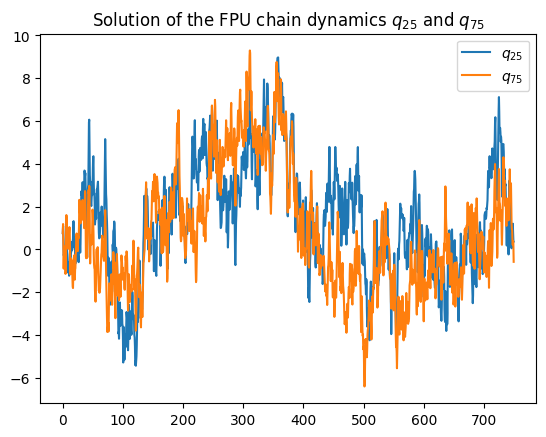

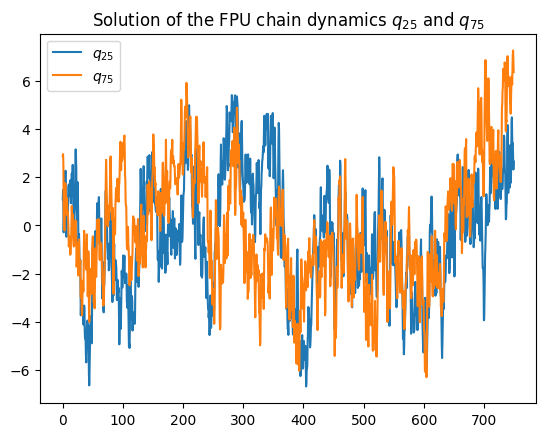

In [10]:
for i, local_q25_store, local_q75_store in results:
        q25_store[:, i*minibatch:(i+1)*minibatch] = local_q25_store
        q75_store[:, i*minibatch:(i+1)*minibatch] = local_q75_store

Toss=int(t_store.size/4)
q25_store=q25_store[Toss:-1,:] 
q75_store=q75_store[Toss:-1,:] 

plt.figure(0)
plt.plot(t_store[Toss:]-t_store[Toss],q25_store[:,0], label=r"$q_{25}$")
plt.plot(t_store[Toss:]-t_store[Toss],q75_store[:,0], label=r"$q_{75}$")
plt.legend()
plt.title(r"Solution of the FPU chain dynamics $q_{25}$ and $q_{75}$")

plt.figure(1)
plt.plot(t_store[Toss:]-t_store[Toss],q25_store[:,1], label=r"$q_{25}$")
plt.plot(t_store[Toss:]-t_store[Toss],q75_store[:,1], label=r"$q_{75}$")
plt.legend()
plt.title(r"Solution of the FPU chain dynamics $q_{25}$ and $q_{75}$")

(400, 400) (400, 400) (400, 400)
(400, 400) (400, 400, 2)


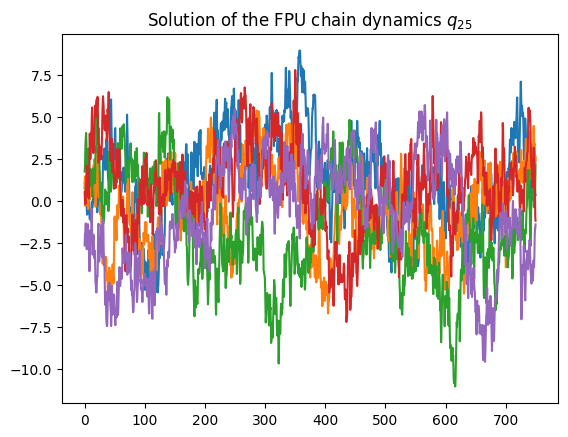

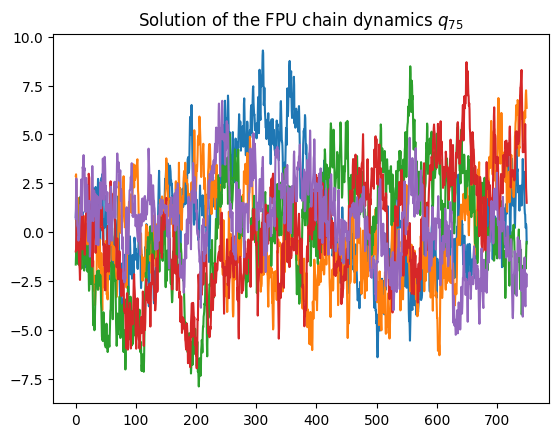

In [11]:
plt.figure(0)
for i in range(5):
    plt.plot(t_store[Toss:]-t_store[Toss],q25_store[:,i])
plt.title(r"Solution of the FPU chain dynamics $q_{25}$")

plt.figure(1)
for i in range(5):
    plt.plot(t_store[Toss:]-t_store[Toss],q75_store[:,i])
plt.title(r"Solution of the FPU chain dynamics $q_{75}$")

###########################################   Construct the sample traj for the LSTM learning 
ini=np.random.randn(sec_length,batch)
Traj25 = q25_store[0:sec_length,:]
Traj75 = q75_store[0:sec_length,:]
print(ini.shape, Traj25.shape, Traj75.shape)

Traj = np.empty((sec_length,batch,2))
Traj[:,:,0] = Traj25
Traj[:,:,1] = Traj75
T=np.arange(len(Traj[:,1]))*delta_t
x=np.linspace(-5,5,sec_length)
print(ini.shape, Traj.shape)

In [12]:
seed = 1234
torch.set_default_dtype(torch.float)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)

In [13]:
# Reformulating data into Torch tensors 
# Input of SINN should be of the form (seq_len, batch, input_size)

ini = np.random.randn(2*sec_length,2*batch).astype(np.float32) 
input = torch.from_numpy(ini.reshape(2*sec_length, batch, 2)).to(device)
batch_validation = batch
val_set = torch.normal(0.0, 1.0, (2*sec_length, batch_validation, 2), device=device)


Traj = Traj.astype(np.float32) 
target = torch.from_numpy(Traj.reshape(sec_length, batch, 2)).to(device)
print('The torch input size is', input.size(), input.dtype)
print('The torch validation size is', val_set.size(), val_set.dtype)
print('The torch target size is', target.size(), target.dtype)

The torch input size is torch.Size([800, 400, 2]) torch.float32
The torch validation size is torch.Size([800, 400, 2]) torch.float32
The torch target size is torch.Size([400, 400, 2]) torch.float32


In [14]:
# Defining Loss functions
LAGS = 400
N = 400
loss_acf_fft = make_loss('acf[fft]', target, lags=LAGS, device=device)
loss_acf_sec_moment = make_loss('acf[fft]', target**2, lags=LAGS, device=device)
loss_acf_bruteforce = make_loss('acf[bruteforce]', target, lags=LAGS, device=device)
loss_acf_randbrute = make_loss('acf[randombrute]', target, lags=LAGS, sample_lags=20, device=device)

loss_ccf_fft = make_loss('ccf[fft]', target, lags=LAGS, device=device)
loss_ccf_sec_moment = make_loss('ccf[fft]', target**2, lags=LAGS, device=device)
loss_ccf_bruteforce = make_loss('ccf[bruteforce]', target, lags=LAGS, device=device)
loss_ccf_randbrute = make_loss('ccf[randombrute]', target, lags=LAGS, sample_lags=20, device=device)

loss_pdf_empirical1 = make_loss('pdf', target, lower=-5, upper=5, n=N, bw=None, device=device)
loss_pdf_empirical2 = make_loss('pdf6', target, lower=-5, upper=5, n=N, bw=None, device=device)
loss_pdf_empirical2D = make_loss('pdf2D', target, lower=-5, upper=5, n=N, bw=None, device=device)

torch.Size([400, 2])


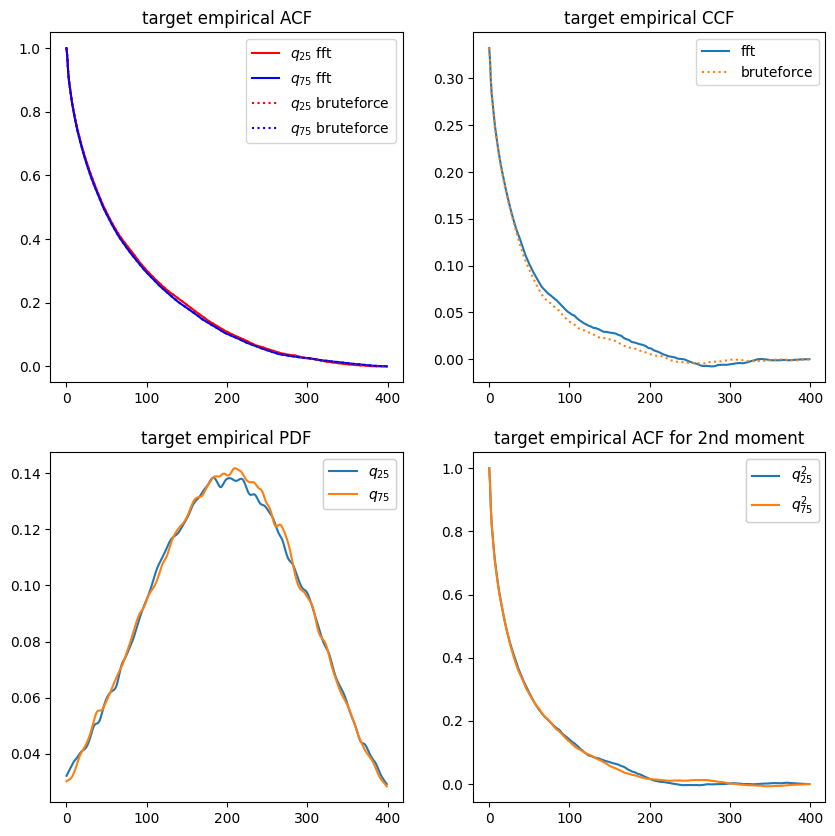

In [15]:
# Plotting target ACFs and PDF
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
axs[0,0].plot(loss_acf_fft._target.cpu()[...,0],'r', label=r'$q_{25}$ fft')
axs[0,0].plot(loss_acf_fft._target.cpu()[...,1],'b', label=r'$q_{75}$ fft')
axs[0,0].plot(loss_acf_bruteforce._target.cpu()[...,0],'r:', label= r'$q_{25}$ bruteforce')
axs[0,0].plot(loss_acf_bruteforce._target.cpu()[...,1], 'b:', label=r'$q_{75}$ bruteforce')
axs[0,0].legend()
axs[0,0].set_title('target empirical ACF')

axs[0,1].plot(loss_ccf_fft._target.cpu()[...,1:3], label='fft')
axs[0,1].plot(loss_ccf_bruteforce._target.cpu()[...,1:3],':',label='bruteforce')
# legend2 = axs[0,1].legend(iter(bf), ('q bf', 'p bf'), loc=1)
# axs[0,1].add_artist(legend2)
axs[0,1].legend()
axs[0,1].set_title('target empirical CCF')

x_grid=-np.linspace(-5,5,num=sec_length)
pdf = axs[1,0].plot(loss_pdf_empirical1._target.cpu())
legend3 = axs[1,0].legend(iter(pdf), (r'$q_{25}$',r'$q_{75}$'), loc=1)
axs[1,0].add_artist(legend3)
axs[1,0].set_title('target empirical PDF')


print(loss_acf_sec_moment._target.cpu().size())
sec_moment = axs[1,1].plot(loss_acf_sec_moment._target.cpu())
legend4 = axs[1,1].legend(iter(sec_moment), (r'$q_{25}^2$',r'$q_{75}^2$'),loc=1)
axs[1,1].set_title('target empirical ACF for 2nd moment')
axs[1,1].add_artist(legend4)

plt.show()

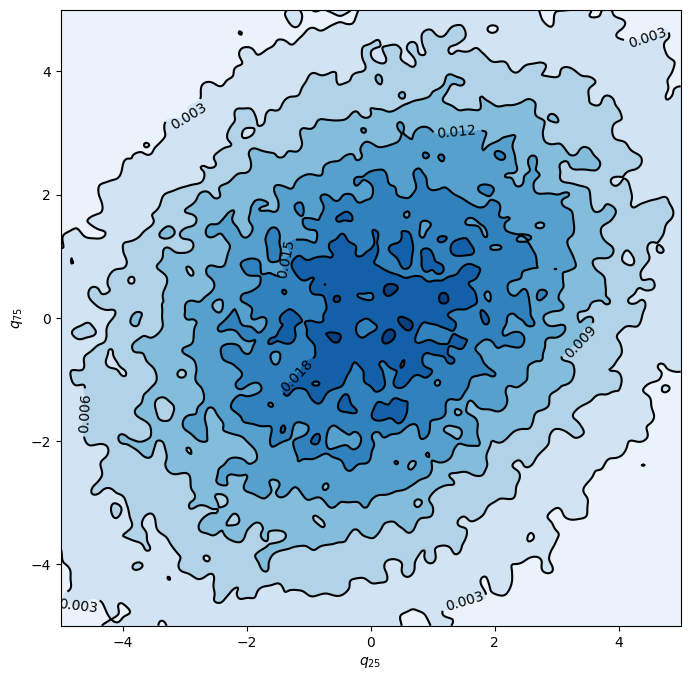

In [16]:
xmin, xmax = -5, 5
ymin, ymax = -5, 5

xx, yy = np.mgrid[xmin:xmax:400j, ymin:ymax:400j]
fig = plt.figure(figsize=(8, 8))
ax = fig.gca()
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)

# Contourf plot
cfset = ax.contourf(xx, yy, loss_pdf_empirical2D._target.cpu(), cmap='Blues')
## Or kernel density estimate plot instead of the contourf plot

# Contour plot
cset = ax.contour(xx, yy, loss_pdf_empirical2D._target.cpu(), colors='k')
# Label plot
ax.clabel(cset, inline=1, fontsize=10)
ax.set_xlabel(r'$q_{25}$')
ax.set_ylabel(r'$q_{75}$')

plt.show()

Text(0.5, 1.0, 'target empirical PDF')

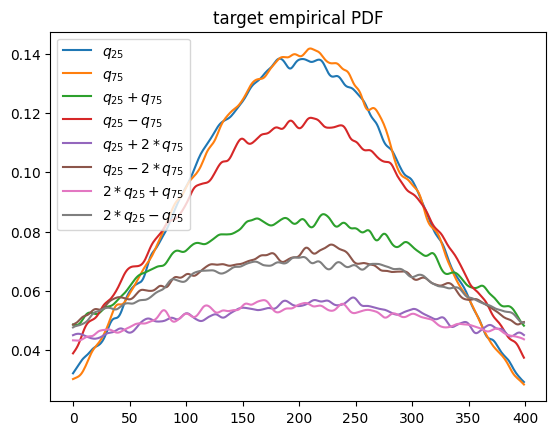

In [17]:
x_grid=-np.linspace(-5,5,num=sec_length)
plt.plot(loss_pdf_empirical1._target.cpu()[...,0],label=r'$q_{25}$')
plt.plot(loss_pdf_empirical1._target.cpu()[...,1],label=r'$q_{75}$')
plt.plot(loss_pdf_empirical2._target.cpu()[...,0],label=r'$q_{25}+q_{75}$')
plt.plot(loss_pdf_empirical2._target.cpu()[...,1],label=r'$q_{25}-q_{75}$')
plt.plot(loss_pdf_empirical2._target.cpu()[...,2],label=r'$q_{25}+2*q_{75}$')
plt.plot(loss_pdf_empirical2._target.cpu()[...,3],label=r'$q_{25}-2*q_{75}$')
plt.plot(loss_pdf_empirical2._target.cpu()[...,4],label=r'$2*q_{25}+q_{75}$')
plt.plot(loss_pdf_empirical2._target.cpu()[...,5],label=r'$2*q_{25}-q_{75}$')
plt.legend()
plt.title('target empirical PDF')

In [18]:
class Model:
    def __init__(self, net):

        self.x_acf_s = None
        self.x_ccf_s = None
        self.x_pdf_s = None
        self.x_pdf2_s = None
        self.x_acf2_s = None
        self.s_collect = []

        self.net = net

        self.T_error=[]
        self.V_error=[]
        self.T_ccf=[]
        self.V_ccf=[]
        self.T_pdf=[]
        self.V_pdf=[]
        self.T_pdf2=[]
        self.V_pdf2=[]
        self.T_acf=[]
        self.V_acf=[]
        self.T_acf2=[]
        self.V_acf2=[]
        self.Step=[]
        self.iter = 0
        self.time = 0

    def train_U(self, x):
        return self.net(x)

    def predict_U(self, x):
        return self.train_U(x)

    def likelihood_loss(self, loss_acf, loss_ccf, loss_pdf, loss_pdf2, loss_acf2):
        loss = torch.reciprocal(2. * self.x_acf_s ** 2) * loss_acf.detach()      \
               + torch.reciprocal(2. * self.x_ccf_s ** 2) * loss_ccf.detach()    \
               + torch.reciprocal(2. * self.x_pdf_s ** 2) * loss_pdf.detach()    \
               + torch.reciprocal(2. * self.x_pdf2_s ** 2) * loss_pdf2.detach()  \
               + torch.reciprocal(2. * self.x_acf2_s ** 2) * loss_acf2.detach()  \
               + torch.log(self.x_acf_s * self.x_ccf_s * self.x_pdf_s * self.x_pdf2_s * self.x_acf2_s)
        return loss

    def true_loss(self, loss_acf, loss_ccf, loss_pdf, loss_pdf2, loss_acf2):
        return torch.reciprocal(2. * self.x_acf_s.detach() ** 2) * loss_acf + torch.reciprocal(2. * self.x_ccf_s.detach() ** 2) * loss_ccf + torch.reciprocal(2. * self.x_pdf_s.detach() ** 2) * loss_pdf + torch.reciprocal(2. * self.x_pdf2_s.detach() ** 2) * loss_pdf2 + torch.reciprocal(2. * self.x_acf2_s.detach() ** 2) * loss_acf2

    def run_baseline(self):
        optimizer_adam = optim.Adam(self.net.parameters(), lr=1e-3)
        for step in range(20000):
            optimizer_adam.zero_grad()
            ini = np.random.randn(2*sec_length, batch*self.net.arch.input_size).astype(np.float32) 
            input = torch.from_numpy(ini.reshape(2*sec_length, batch, self.net.arch.input_size)).to(device)
            prediction, _ = self.train_U(input)
            prediction = prediction[-LAGS:,:,:]
            loss = loss_acf_fft(prediction)+ loss_ccf_fft(prediction)+loss_pdf_empirical1(prediction)+loss_pdf_empirical2(prediction)+loss_acf_sec_moment(prediction**2)
            loss.backward()
            optimizer_adam.step()
            self.iter += 1
            if step % 50 == 0: 
                with torch.no_grad():
                    loss = loss_acf_fft(prediction)+loss_ccf_fft(prediction)+loss_pdf_empirical1(prediction)+loss_pdf_empirical2(prediction)+loss_acf_sec_moment(prediction**2)
                    pred_val, _ = self.predict_U(val_set)
                    pred_val = pred_val[-LAGS:,:,:]
                    loss_val = loss_acf_bruteforce(pred_val)+loss_ccf_bruteforce(pred_val)+ loss_pdf_empirical1(pred_val)+ loss_pdf_empirical2(pred_val) + loss_acf_sec_moment(pred_val**2)
                    acf = loss_acf_bruteforce(pred_val)
                    ccf = loss_ccf_bruteforce(pred_val)
                    pdf = loss_pdf_empirical1(pred_val)
                    pdf2 = loss_pdf_empirical2(pred_val)
                    acf_sec_moment = loss_acf_sec_moment(pred_val**2)
                    print('[%d]-th step loss: %.4f, %.4f, acf: %.5f, ccf: %.5f, pdf: %.5f, pdf2: %.5f, acf2: %.5f' % (step, loss, loss_val, acf, ccf, pdf, pdf2, acf_sec_moment))
                    self.T_acf.append(loss_acf_fft(prediction).detach().cpu().numpy())
                    self.V_acf.append(loss_acf_bruteforce(pred_val).detach().cpu().numpy())
                    self.T_ccf.append(loss_ccf_fft(prediction).detach().cpu().numpy())
                    self.V_ccf.append(loss_ccf_bruteforce(pred_val).detach().cpu().numpy())
                    self.T_pdf.append(loss_pdf_empirical1(prediction).detach().cpu().numpy())
                    self.V_pdf.append(loss_pdf_empirical1(pred_val).detach().cpu().numpy())
                    self.T_pdf2.append(loss_pdf_empirical2(prediction).detach().cpu().numpy())
                    self.V_pdf2.append(loss_pdf_empirical2(pred_val).detach().cpu().numpy())
                    self.T_acf2.append(loss_acf_sec_moment(prediction**2).detach().cpu().numpy())
                    self.V_acf2.append(loss_acf_sec_moment(pred_val**2).detach().cpu().numpy())
                    self.T_error.append(loss.detach().cpu().numpy())
                    self.V_error.append(loss_val.detach().cpu().numpy())
                    self.Step.append(step)
            if loss <= 0.0005 and loss_val <= 0.0005:
                break

        if loss > 0.0005 or loss_val > 0.0005:
            print ('Training failed')
        print('Training finished')



    def run_AW(self):
        self.x_acf_s = nn.Parameter(self.x_acf_s, requires_grad=True)
        self.x_ccf_s = nn.Parameter(self.x_ccf_s, requires_grad=True)
        self.x_pdf_s = nn.Parameter(self.x_pdf_s, requires_grad=True)
        self.x_pdf2_s = nn.Parameter(self.x_pdf2_s, requires_grad=True)
        self.x_acf2_s = nn.Parameter(self.x_acf2_s, requires_grad=True)


        optimizer_adam = optim.Adam(self.net.parameters(), lr=1e-3)
        optimizer_adam_weight = optim.Adam([self.x_acf_s] + [self.x_ccf_s] + [self.x_pdf_s] + [self.x_pdf2_s] + [self.x_acf2_s],
                                                     lr=1e-3)

        for step in range(20000):
            self.s_collect.append([self.iter, self.x_acf_s.item(), self.x_ccf_s.item(), self.x_pdf_s.item(), self.x_pdf2_s.item(), self.x_acf2_s.item()])

            optimizer_adam.zero_grad()
            ini = np.random.randn(2*sec_length, batch*self.net.arch.input_size).astype(np.float32) 
            input = torch.from_numpy(ini.reshape(2*sec_length, batch, self.net.arch.input_size)).to(device)
            prediction, _ = self.train_U(input)
            prediction = prediction[-LAGS:,:,:]
            loss = self.true_loss(loss_acf_fft(prediction), loss_ccf_fft(prediction),loss_pdf_empirical1(prediction),loss_pdf_empirical2(prediction),loss_acf_sec_moment(prediction**2))
            loss.backward()
            optimizer_adam.step()
            self.iter += 1
            if step % 50 == 0: 
                with torch.no_grad():
                    loss = loss_acf_fft(prediction)+loss_ccf_fft(prediction)+loss_pdf_empirical1(prediction)+loss_pdf_empirical2(prediction)+loss_acf_sec_moment(prediction**2)
                    pred_val, _ = self.predict_U(val_set)
                    pred_val = pred_val[-LAGS:,:,:]
                    loss_val = loss_acf_bruteforce(pred_val)+loss_ccf_bruteforce(pred_val)+ loss_pdf_empirical1(pred_val) + loss_pdf_empirical2(pred_val) + loss_acf_sec_moment(pred_val**2)
                    acf = loss_acf_bruteforce(pred_val)
                    ccf = loss_ccf_bruteforce(pred_val)
                    pdf = loss_pdf_empirical1(pred_val)
                    pdf2 = loss_pdf_empirical2(pred_val)
                    acf_sec_moment = loss_acf_sec_moment(pred_val**2)
                    print('[%d]-th step loss: %.4f, %.4f, acf: %.5f, ccf: %.5f, pdf: %.5f, pdf2: %.5f, acf2: %.5f' % (step, loss, loss_val, acf, ccf, pdf, pdf2, acf_sec_moment))
                    self.T_acf.append(loss_acf_fft(prediction).detach().cpu().numpy())
                    self.V_acf.append(loss_acf_bruteforce(pred_val).detach().cpu().numpy())
                    self.T_ccf.append(loss_ccf_fft(prediction).detach().cpu().numpy())
                    self.V_ccf.append(loss_ccf_bruteforce(pred_val).detach().cpu().numpy())
                    self.T_pdf.append(loss_pdf_empirical1(prediction).detach().cpu().numpy())
                    self.V_pdf.append(loss_pdf_empirical1(pred_val).detach().cpu().numpy())
                    self.T_pdf2.append(loss_pdf_empirical2(prediction).detach().cpu().numpy())
                    self.V_pdf2.append(loss_pdf_empirical2(pred_val).detach().cpu().numpy())
                    self.T_acf2.append(loss_acf_sec_moment(prediction**2).detach().cpu().numpy())
                    self.V_acf2.append(loss_acf_sec_moment(pred_val**2).detach().cpu().numpy())
                    self.T_error.append(loss.detach().cpu().numpy())
                    self.V_error.append(loss_val.detach().cpu().numpy())
                    self.Step.append(step)
            if loss <= 0.0005 and loss_val <= 0.0005:
                break
            optimizer_adam_weight.zero_grad()
            loss = self.likelihood_loss(loss_acf_fft(prediction), loss_ccf_fft(prediction),loss_pdf_empirical1(prediction),loss_pdf_empirical2(prediction),loss_acf_sec_moment(prediction**2))
            loss.backward()
            optimizer_adam_weight.step()
            
        if loss > 0.0005 or loss_val > 0.0005:
            print ('Training failed')
        print('Training finished')


    def train(self):
        self.x_acf_s = torch.tensor(2.).float()
        self.x_ccf_s = torch.tensor(2.).float()
        self.x_pdf_s = torch.tensor(2.).float()
        self.x_pdf2_s = torch.tensor(2.).float()
        self.x_acf2_s = torch.tensor(2.).float()
        start_time = time.time()
        if model_type == 0:
            self.run_baseline()
        elif model_type == 1:
            self.run_AW()
        elapsed = time.time() - start_time
        self.time = elapsed
        print('Training time: %.2f' % elapsed)
        avg_time = elapsed/self.iter
        print('Training time per iteration: %.2f' % avg_time)
        print('Number of Iterations:%d' %self.iter)

In [19]:
model_type = 1

In [20]:
### Defining SINN model
net = SINN(2, 50, 2, 2,'LSTM').to(device) # input dimension, hidden size, number of layers, output dimension
model = Model(net=net)
model.train()

[0]-th step loss: 0.7011, 0.6988, acf: 0.07576, ccf: 0.00446, pdf: 0.29059, pdf2: 0.29626, acf2: 0.03171
[50]-th step loss: 0.0869, 0.0812, acf: 0.01789, ccf: 0.01948, pdf: 0.02698, pdf2: 0.01367, acf2: 0.00316
[100]-th step loss: 0.0196, 0.0190, acf: 0.00512, ccf: 0.00210, pdf: 0.00689, pdf2: 0.00332, acf2: 0.00155
[150]-th step loss: 0.0292, 0.0250, acf: 0.00166, ccf: 0.01117, pdf: 0.00615, pdf2: 0.00439, acf2: 0.00165
[200]-th step loss: 0.0257, 0.0256, acf: 0.00773, ccf: 0.00456, pdf: 0.00602, pdf2: 0.00382, acf2: 0.00346
[250]-th step loss: 0.0183, 0.0169, acf: 0.00204, ccf: 0.00076, pdf: 0.01054, pdf2: 0.00127, acf2: 0.00229
[300]-th step loss: 0.0375, 0.0363, acf: 0.00988, ccf: 0.00393, pdf: 0.01194, pdf2: 0.00196, acf2: 0.00855
[350]-th step loss: 0.0552, 0.0555, acf: 0.02871, ccf: 0.00629, pdf: 0.00415, pdf2: 0.00501, acf2: 0.01135
[400]-th step loss: 0.0362, 0.0445, acf: 0.01785, ccf: 0.00652, pdf: 0.01061, pdf2: 0.00557, acf2: 0.00391
[450]-th step loss: 0.0204, 0.0197, acf:

[3850]-th step loss: 0.0168, 0.0166, acf: 0.00733, ccf: 0.00010, pdf: 0.00651, pdf2: 0.00255, acf2: 0.00010
[3900]-th step loss: 0.0167, 0.0164, acf: 0.00742, ccf: 0.00005, pdf: 0.00640, pdf2: 0.00244, acf2: 0.00010
[3950]-th step loss: 0.0166, 0.0166, acf: 0.00861, ccf: 0.00010, pdf: 0.00552, pdf2: 0.00235, acf2: 0.00007
[4000]-th step loss: 0.0167, 0.0171, acf: 0.00895, ccf: 0.00010, pdf: 0.00563, pdf2: 0.00233, acf2: 0.00010
[4050]-th step loss: 0.0149, 0.0159, acf: 0.00786, ccf: 0.00009, pdf: 0.00554, pdf2: 0.00233, acf2: 0.00008
[4100]-th step loss: 0.0171, 0.0166, acf: 0.00807, ccf: 0.00005, pdf: 0.00604, pdf2: 0.00230, acf2: 0.00010
[4150]-th step loss: 0.0172, 0.0169, acf: 0.00881, ccf: 0.00008, pdf: 0.00547, pdf2: 0.00235, acf2: 0.00015
[4200]-th step loss: 0.0154, 0.0162, acf: 0.00753, ccf: 0.00006, pdf: 0.00613, pdf2: 0.00239, acf2: 0.00007
[4250]-th step loss: 0.0164, 0.0156, acf: 0.00727, ccf: 0.00017, pdf: 0.00592, pdf2: 0.00219, acf2: 0.00008
[4300]-th step loss: 0.0148,

In [21]:
net.arch.input_size

2

In [22]:
def draw_loss(model):
    ### Plotting the training and the generalization error
    fig = plt.figure(1)
    ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
    plt.title("Error plot",fontsize=15) 
    plt.yscale('log')
    plt.plot(model.Step, model.T_error,'r',label='Training error')
    plt.plot(model.Step, model.V_error,'b--',label='Validation error')
#     plt.loglog(model.Step, model.T_error,'r',label='Training error')
#     plt.loglog(model.Step, model.V_error,'b--',label='Validation error')
    plt.xlabel(r'Iteration $n$',fontsize=15)
    plt.ylabel(r'$L_2$ Loss',fontsize=15)
    plt.legend(frameon=False,fontsize=15)

In [23]:
def draw_errors(model):
    ### Plotting the training and the generalization error
    fig = plt.figure(1)
    ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
    plt.title("Error plot for loss functions w/o coeff",fontsize=15)
    plt.yscale('log')
    plt.plot(model.Step, model.T_error,'k',label='Training error')
    plt.plot(model.Step, model.V_error,'k--')
    plt.plot(model.Step, model.T_acf,'r',label='acf error')
    plt.plot(model.Step, model.V_acf,'r--')
    plt.plot(model.Step, model.T_ccf,'b',label='ccf error')
    plt.plot(model.Step, model.V_ccf,'b--')
    plt.plot(model.Step, model.T_pdf,'y',label='pdf error')
    plt.plot(model.Step, model.V_pdf,'y--')
    plt.plot(model.Step, model.T_pdf2,'m',label='pdf2 error')
    plt.plot(model.Step, model.V_pdf2,'m--')
    plt.plot(model.Step, model.T_acf2,'g',label='acf2 error')
    plt.plot(model.Step, model.V_acf2,'g--')
    
#     plt.loglog(model.Step, model.T_error,'k',label='Training error')
#     plt.loglog(model.Step, model.V_error,'k--')
#     plt.loglog(model.Step, model.T_acf,'r',label='acf error')
#     plt.loglog(model.Step, model.V_acf,'r--')
#     plt.loglog(model.Step, model.T_ccf,'b',label='ccf error')
#     plt.loglog(model.Step, model.V_ccf,'b--')
#     plt.loglog(model.Step, model.T_pdf,'y',label='pdf error')
#     plt.loglog(model.Step, model.V_pdf,'y--')
#     plt.loglog(model.Step, model.T_pdf2,'m',label='pdf2 error')
#     plt.loglog(model.Step, model.V_pdf2,'m--')
#     plt.loglog(model.Step, model.T_acf2,'g',label='acf2 error')
#     plt.loglog(model.Step, model.V_acf2,'g--')
    plt.xlabel(r'Training times $n$',fontsize=15)
    plt.ylabel(r'$l_1+l_2$',fontsize=15)
    plt.legend(frameon=False,fontsize=15, bbox_to_anchor=(1.1, 1.05))

In [24]:
def draw_adaptive_w(model):
    s_collect = np.array(model.s_collect)
    np.savetxt('s_RAM-AW.npy', s_collect)
#     plt.yscale('log')
    plt.plot(s_collect[:, 0], s_collect[:, 1], 'r-', label=r'$\epsilon_{acf}$')
    plt.plot(s_collect[:, 0], s_collect[:, 2], 'b-', label='$\epsilon_{ccf}$')
    plt.plot(s_collect[:, 0], s_collect[:, 3], 'y-', label='$\epsilon_{pdf}$')
    plt.plot(s_collect[:, 0], s_collect[:, 4], 'm-', label='$\epsilon_{pdf2}$')
    plt.plot(s_collect[:, 0], s_collect[:, 5], 'g-', label='$\epsilon_{acf2}$')
    plt.xlabel('$Iters$')
    plt.ylabel('$s$')
#     plt.xscale('log')
    plt.legend()
#     plt.savefig('2dpossion_S_RAM-AW.pdf')
    plt.show()

In [25]:
def draw_epoch_w(model):
    s_collect = np.array(model.s_collect)
    np.savetxt('s_RAM-AW.npy', s_collect)
    plt.yscale('log')
    plt.plot(s_collect[:, 0], np.reciprocal(2. * s_collect[:, 1]**2), 'r-', label=r'$\frac{1}{2\epsilon_{acf}^2}$')
    plt.plot(s_collect[:, 0], np.reciprocal(2. * s_collect[:, 2]**2), 'b-', label=r'$\frac{1}{2\epsilon_{ccf}^2}$')
    plt.plot(s_collect[:, 0], np.reciprocal(2. * s_collect[:, 3]**2), 'y-', label=r'$\frac{1}{2\epsilon_{pdf}^2}$')
    plt.plot(s_collect[:, 0], np.reciprocal(2. * s_collect[:, 4]**2), 'm-', label=r'$\frac{1}{2\epsilon_{pdf2}^2}$')
    plt.plot(s_collect[:, 0], np.reciprocal(2. * s_collect[:, 5]**2), 'g-', label=r'$\frac{1}{2\epsilon_{acf2}^2}$')
    plt.xlabel('$Iters$')
    plt.ylabel('$\omega$')
    plt.legend()
#     plt.savefig('2dpossion_S_RAM-AW.pdf')
    plt.show()

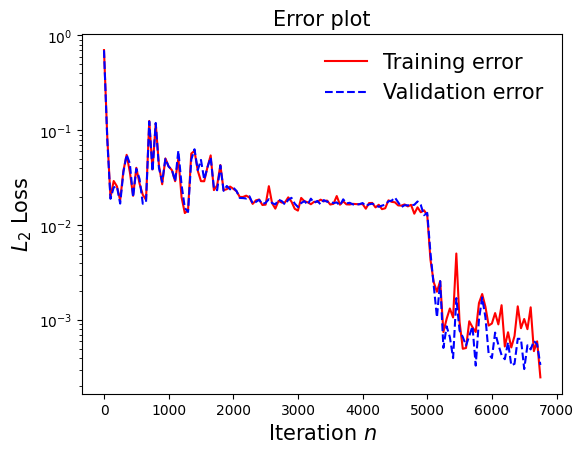

In [26]:
draw_loss(model)

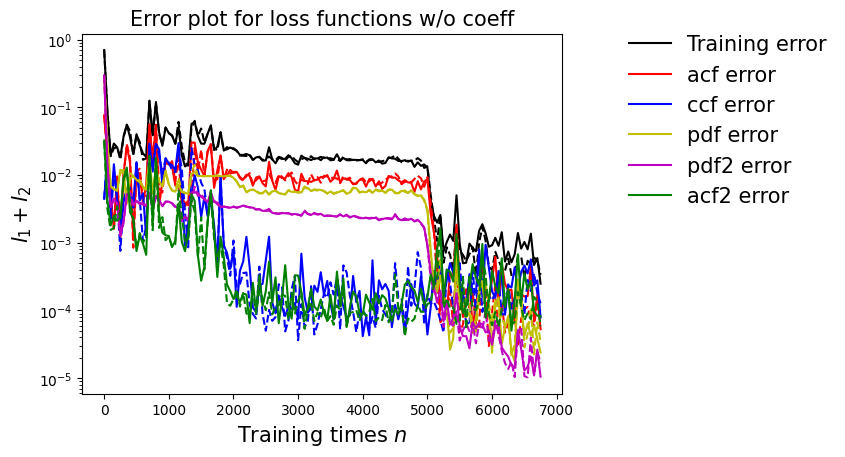

In [27]:
draw_errors(model)

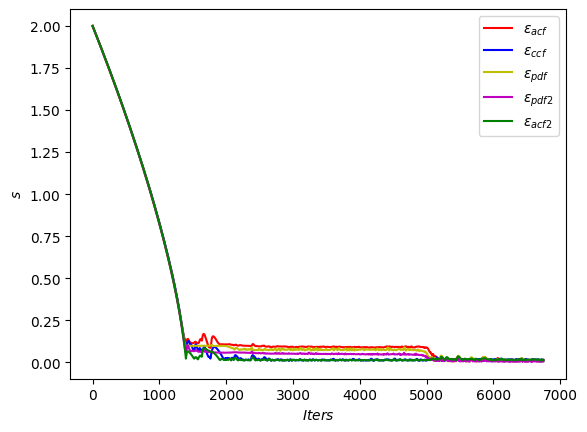

In [28]:
draw_adaptive_w(model)

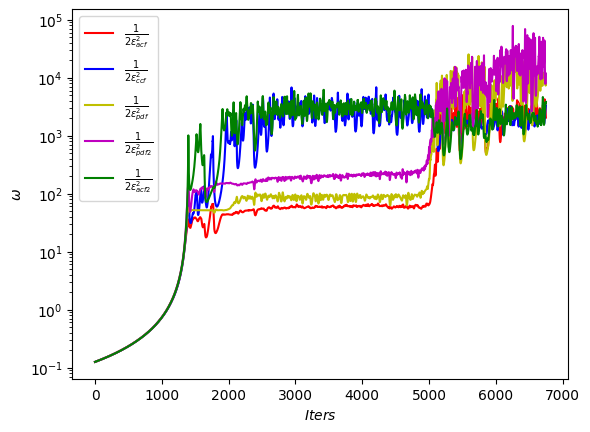

In [29]:
draw_epoch_w(model)

## Test 1: plot the sample path generated by SINN and the exact sample path 

In [30]:
def test1(model):
    ran_input=torch.randn(input.size(),dtype=input.dtype,layout=input.layout, device=input.device)
    Pred,_= model.predict_U(ran_input)
    prediction=Pred[-sec_length:,:,:].detach().cpu().numpy().reshape(sec_length, batch, 2)
    # Test 1: plot the sample path generated by SINN and the exact sample path 
    skip = 0

    fig = plt.figure(0)
    plt.title("MD trajectories",fontsize=15) 
    plt.plot(T[skip:]-T[skip], Traj[skip:, 0])
    plt.xlabel(r'$t$',fontsize=15)
    plt.ylabel(r'$q_{25}(t)$ and $q_{75}(t)$',fontsize=15)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15) 


    fig = plt.figure(1)
    plt.title("SINN trajectories",fontsize=15)    
    plt.plot(T[skip:]-T[skip], prediction[skip:, 0])
    plt.xlabel(r'$t$',fontsize=15)
    plt.ylabel(r'$q_{25}(t)$ and $q_{75}(t)$',fontsize=15)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)

## Test 2: plot the CCF of the sample path generated by the SINN and the exact CCF

In [31]:
def test2(model):
    ran_input=torch.randn(input.size(),dtype=input.dtype,layout=input.layout, device=input.device)
    Pred,_= model.predict_U(ran_input)
    
    # Test 2: plot the CCF of the sample path generated by the SINN and the exact CCF  
    acf_p=StatLoss.acf(Pred[-sec_length:,:,:])
    acf_t=StatLoss.acf(target)
    corr_p1=acf_p.detach().cpu().numpy()
    corr_t1=acf_t.detach().cpu().numpy()
    ccf_p=StatLoss.ccf(Pred[-sec_length:,:,:])
    ccf_t=StatLoss.ccf(target)
    corr_p2=ccf_p.detach().cpu().numpy()
    corr_t2=ccf_t.detach().cpu().numpy()
    
    fig = plt.figure(0)
    ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
    plt.title(r'Normalized ACF of $\tilde{q}_1$',fontsize=15)    
    plt.plot(T, corr_t1[...,0],'r',label='Exact')        # correlation function of the target 
    plt.plot(T, corr_p1[...,0], 'b--',label='SINN')        # Correlation function after the training      # Correlation function after the training 
    plt.xlabel(r'$t$',fontsize=15)
    plt.ylabel(r'$C(t)/C(0)$',fontsize=15)
    plt.xticks(fontsize=15)
#     plt.xlim(0,T[-1])
    plt.yticks([-0.2,0,0.2,0.4,0.6,0.8,1.0],fontsize=15)
    plt.legend()
    
    fig = plt.figure(1)
    ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
    plt.title(r'Normalized ACF of $\tilde{q}_2$',fontsize=15)          
    plt.plot(T, corr_t1[...,-1],'r',label='Exact')        # correlation function of the target 
    plt.plot(T, corr_p1[...,-1], 'b--',label='SINN')     # Correlation function after the training      # Correlation function after the training 
    plt.xlabel(r'$t$',fontsize=15)
    plt.ylabel(r'$C(t)/C(0)$',fontsize=15)
    plt.xticks(fontsize=15)
#     plt.xlim(0,T[-1])
    plt.yticks([-0.2,0,0.2,0.4,0.6,0.8,1.0],fontsize=15)
    plt.legend()
    
    fig = plt.figure(2)
    ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
    plt.title(r'Normalized CCF',fontsize=15)    
    plt.plot(T, corr_t2[:,:],'r')        # correlation function of the target 
    plt.plot(T, corr_p2[:,:], 'b--')        # Correlation function after the training      # Correlation function after the training 
    plt.xlabel(r'$t$',fontsize=15)
    plt.ylabel(r'$C(t)/C(0)$',fontsize=15)
    plt.xticks(fontsize=15)
#     plt.ylim(-0.05,0.05)

## Test 3: plot the PDF of the sample path generated by SINN and the exact PDF  

In [32]:
def test3(model):
    ran_input=torch.randn(input.size(),dtype=input.dtype,layout=input.layout, device=input.device)
    Pred,_= model.predict_U(ran_input)
    
    # Test 3: plot the PDF of the sample path generated by SINN and the exact PDF  
    rho_data =  StatLoss.gauss_kde(target, -5, 5, 400, None).cpu()
    rho_input = StatLoss.gauss_kde(ran_input, -5, 5, 400, None).cpu()
    rho_prediction = StatLoss.gauss_kde(Pred[-sec_length:,:,:].detach(), -5, 5, 400,None).cpu()
    
    rho_data2 =  StatLoss.gauss_kde6(target, -5, 5, 400, None).cpu()
    rho_prediction2 = StatLoss.gauss_kde6(Pred[-sec_length:,:,:].detach(), -5, 5, 400,None).cpu()


    x=np.linspace(-5, 5, 400)
    fig = plt.figure(0)
    ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
    plt.title(r"Equilibrium probability density function",fontsize=15)    
    plt.plot(x, rho_data.numpy()[...,0],label=r'Exact PDF of $q_{25}$')    # target PDF
    plt.plot(x, rho_data.numpy()[...,1],label=r'Exact PDF of $q_{75}$')    # target PDF
#     plt.plot(x, rho_input.numpy(), 'b--', label=r'PDF of the input')     # PDF of the input
    plt.plot(x, rho_prediction.numpy()[...,0], ':',label=r'PDF of the output $q_{25}$')  # PDF after the training 
    plt.plot(x, rho_prediction.numpy()[...,1], ':',label=r'PDF of the output $q_{75}$')  # PDF after the training 
    plt.xlim(-5,5)
#     plt.ylim(0,0.6)
    plt.xlabel(r'$x$',fontsize=15)
    plt.ylabel(r'$\rho(x)$',fontsize=15)
    plt.legend(frameon=False,fontsize=10)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    
    
    fig = plt.figure(1)
    ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
    plt.title(r"Equilibrium probability density function of sum and diff",fontsize=15)    
    plt.plot(x, rho_data2.numpy()[...,0],label=r'Exact PDF of $q_{25}+q_{75}$')    # target PDF
    plt.plot(x, rho_data2.numpy()[...,1],label=r'Exact PDF of $q_{25}-q_{75}$')    # target PDF
#     plt.plot(x, rho_input.numpy(), 'b--', label=r'PDF of the input')     # PDF of the input
    plt.plot(x, rho_prediction2.numpy()[...,0], ':',label=r'PDF of the output $q_{25}+q_{75}$')  # PDF after the training 
    plt.plot(x, rho_prediction2.numpy()[...,1], ':',label=r'PDF of the output $q_{25}-q_{75}$')  # PDF after the training 
    plt.xlim(-5,5)
#     plt.ylim(0,0.6)
    plt.xlabel(r'$x$',fontsize=15)
    plt.ylabel(r'$\rho(x)$',fontsize=15)
    plt.legend(frameon=False,fontsize=10)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    
    fig = plt.figure(2)
    ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
    plt.title(r"Equilibrium probability density function of sum and diff",fontsize=15)    
    plt.plot(x, rho_data2.numpy()[...,2],label=r'Exact PDF of $q_{25}+2q_{75}$')    # target PDF
    plt.plot(x, rho_data2.numpy()[...,3],label=r'Exact PDF of $q_{25}-2q_{75}$')    # target PDF
#     plt.plot(x, rho_input.numpy(), 'b--', label=r'PDF of the input')     # PDF of the input
    plt.plot(x, rho_prediction2.numpy()[...,2], ':',label=r'PDF of the output $q_{25}+2q_{75}$')  # PDF after the training 
    plt.plot(x, rho_prediction2.numpy()[...,3], ':',label=r'PDF of the output $q_{25}-2q_{75}$')  # PDF after the training 
    plt.xlim(-5,5)
#     plt.ylim(0,0.6)
    plt.xlabel(r'$x$',fontsize=15)
    plt.ylabel(r'$\rho(x)$',fontsize=15)
    plt.legend(frameon=False,fontsize=10)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    
    fig = plt.figure(3)
    ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
    plt.title(r"Equilibrium probability density function of sum and diff",fontsize=15)    
    plt.plot(x, rho_data2.numpy()[...,4],label=r'Exact PDF of $2q_{25}+q_{75}$')    # target PDF
    plt.plot(x, rho_data2.numpy()[...,5],label=r'Exact PDF of $2q_{25}-q_{75}$')    # target PDF
#     plt.plot(x, rho_input.numpy(), 'b--', label=r'PDF of the input')     # PDF of the input
    plt.plot(x, rho_prediction2.numpy()[...,4], ':',label=r'PDF of the output $2q_{25}+q_{75}$')  # PDF after the training 
    plt.plot(x, rho_prediction2.numpy()[...,5], ':',label=r'PDF of the output $2q_{25}-q_{75}$')  # PDF after the training 
    plt.xlim(-5,5)
#     plt.ylim(0,0.6)
    plt.xlabel(r'$x$',fontsize=15)
    plt.ylabel(r'$\rho(x)$',fontsize=15)
    plt.legend(frameon=False,fontsize=10)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)

## Test 4: Comparing the higher-order ACF

In [33]:
def test4(model):
    ran_input=torch.randn(input.size(),dtype=input.dtype,layout=input.layout, device=input.device)
    Pred,_= model.predict_U(ran_input)
    prediction=Pred[-sec_length:,:,:].detach().cpu().numpy().reshape(sec_length, batch, 2)
    
    # Test 4: Comparing the higher-order ACF
    acf2=StatLoss.acf(target**2)
    pred_norm=torch.from_numpy((prediction).reshape(sec_length, batch,2))
    acf2_app=StatLoss.acf(pred_norm**2)

    
    fig = plt.figure(0)
    ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
    plt.title(r'Normalized ACF of $q_{25}^2$',fontsize=15)    
    plt.plot(T, acf2.detach().cpu().numpy()[...,0],'r',label='Exact')        # correlation function of the target 
    plt.plot(T, acf2_app.detach().cpu().numpy()[...,0], 'b--',label='SINN')        # Correlation function after the training      # Correlation function after the training 
    plt.xlabel(r'$t$',fontsize=15)
    plt.ylabel(r'$C(t)/C(0)$',fontsize=15)
    plt.xticks(fontsize=15)
    plt.xlim(0,T[-1])
    plt.yticks([-0.2,0,0.2,0.4,0.6,0.8,1.0],fontsize=15)
    plt.legend()
    
    fig = plt.figure(1)
    ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
    plt.title(r'Normalized ACF of $q_{75}^2$',fontsize=15)          
    plt.plot(T, acf2.detach().cpu().numpy()[...,1],'r',label='Exact')        # correlation function of the target 
    plt.plot(T, acf2_app.detach().cpu().numpy()[...,1], 'b--',label='SINN')     # Correlation function after the training      # Correlation function after the training 
    plt.xlabel(r'$t$',fontsize=15)
    plt.ylabel(r'$C(t)/C(0)$',fontsize=15)
    plt.xticks(fontsize=15)
    plt.xlim(0,T[-1])
    plt.yticks([-0.2,0,0.2,0.4,0.6,0.8,1.0],fontsize=15)
    plt.legend()    

## Test 5: plot the expolation result, i.e. Prediction of the FPU-Langevin dynamics for longer time 

In [34]:
def test5(model):
    # Test 5: plot the expolation result, i.e. Prediction of the FPU-Langevin dynamics for longer time 
    [a,b,c]=input.size()
    skip=20
    scale=10
    burnin=3
    fold=800
    batch_new=50
    ran_input=torch.randn(((scale-burnin)*a,batch_new,c),dtype=input.dtype,layout=input.layout, device=input.device)
    Pred_L, _= model.predict_U(ran_input)
    prediction_ext=Pred_L.detach().cpu().numpy().reshape((scale-burnin)*a, batch_new,2)
    ccf_p=StatLoss.ccf(Pred_L,method='bruteforce')

    LT=np.linspace(0,(scale-burnin)*a*delta_t,num=(scale-burnin)*a+1)
    LT=LT[0:-1]


    fig = plt.figure(0)
    ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
    plt.title("Short-time trajectories",fontsize=15)
    plt.plot(t_store[Toss:]-t_store[Toss],q25_store[:,0],label='MD simulation')
    plt.plot(LT[skip:]-LT[skip], prediction_ext[skip:, 0, 0],'--',label='SINN simulation')
    plt.xlim([0,80])
    plt.xlabel(r'$t$',fontsize=15)
    plt.ylabel(r'$q_{25}(t)$',fontsize=15)
    plt.legend(frameon=False,fontsize=15)
    plt.yticks([-2,-1,0,1,2],fontsize=15)
    plt.xticks(fontsize=15)



    fig = plt.figure(figsize=(16, 4))
    ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
    plt.title("Long-time trajectories",fontsize=15)
    plt.plot(t_store[Toss:]-t_store[Toss],q25_store[:,0],label='MD simulation')
    plt.plot(LT[skip:]-LT[skip], prediction_ext[skip:, 0, 0],'--',label='SINN simulation')
    plt.xlim([0,500])
    plt.xlabel(r'$t$',fontsize=15)
    plt.ylabel(r'$q_{25}(t)$',fontsize=15)
    plt.legend(frameon=False,fontsize=15)
    plt.yticks([-2,-1,0,1,2],fontsize=15)
    plt.xticks(fontsize=15)

    fig = plt.figure(2)
    ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
    plt.title("Short-time trajectories",fontsize=15)
    plt.plot(t_store[Toss:]-t_store[Toss],q75_store[:,0],label='MD simulation')
    plt.plot(LT[skip:]-LT[skip], prediction_ext[skip:, 0, 1],'--',label='SINN simulation')
    plt.xlim([0,80])
    plt.xlabel(r'$t$',fontsize=15)
    plt.ylabel(r'$q_{75}(t)$',fontsize=15)
    plt.legend(frameon=False,fontsize=15)
    plt.yticks([-2,-1,0,1,2],fontsize=15)
    plt.xticks(fontsize=15)



    fig = plt.figure(figsize=(16, 4))
    ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
    plt.title("Long-time trajectories",fontsize=15)
    plt.plot(t_store[Toss:]-t_store[Toss],q75_store[:,0],label='MD simulation')
    plt.plot(LT[skip:]-LT[skip], prediction_ext[skip:, 0, 1],'--',label='SINN simulation')
    plt.xlim([0,500])
    plt.xlabel(r'$t$',fontsize=15)
    plt.ylabel(r'$q_{75}(t)$',fontsize=15)
    plt.legend(frameon=False,fontsize=15)
    plt.yticks([-2,-1,0,1,2],fontsize=15)
    plt.xticks(fontsize=15)

## Test 6: comparing scatter plots

In [35]:
def test6(model):
    # Test 6: scatter plot of SINN
    ran_input=torch.randn(input.size(),dtype=input.dtype,layout=input.layout, device=input.device)
    Pred,_= model.predict_U(ran_input)
    prediction=Pred[-sec_length:,:,:].detach().cpu().numpy().reshape(sec_length, batch, 2)
    
    fig = plt.figure(0)
    plt.title("MD trajectories",fontsize=15) 
    plt.scatter(Traj[:,:,0], Traj[:,:,1])
    plt.xlabel(r'$q_{25}(t)$',fontsize=15)
    plt.ylabel(r'$q_{75}(t)$',fontsize=15)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15) 


    fig = plt.figure(1)
    plt.title("SINN trajectories",fontsize=15)    
    plt.scatter(prediction[:,:,0],prediction[:,:,1])
    plt.xlabel(r'$q_{25}(t)$',fontsize=15)
    plt.ylabel(r'$q_{75}(t)$',fontsize=15)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)

## Test 7: comparing joint PDF contours

In [36]:
def test7(model):
    # Test 5: scatter plot of SINN
    ran_input=torch.randn(input.size(),dtype=input.dtype,layout=input.layout, device=input.device)
    Pred,_= model.predict_U(ran_input)
    prediction=Pred[-sec_length:,:,:].detach().cpu().numpy().reshape(sec_length, batch, 2)
    
    rho_data =  StatLoss.gauss_kde2D(target, -5, 5, 400, None).cpu()
    rho_prediction = StatLoss.gauss_kde2D(Pred[-sec_length:,:,:].detach(), -5, 5, 400,None).cpu()
    
    fig = plt.figure(0, figsize=(5, 5))
    plt.title("PDF Contours",fontsize=15) 
    xmin, xmax = -5, 5
    ymin, ymax = -5, 5

    xx, yy = np.mgrid[xmin:xmax:400j, ymin:ymax:400j]
    axs[0]  = fig.gca()
    plt.xlim(xmin, xmax)
    plt.ylim(ymin, ymax)
    
    plt.contour(xx,yy,rho_data.numpy(),colors='r')
    plt.contour(xx,yy,rho_prediction.numpy(),colors='b',linestyles='dashed')

    plt.xlabel(r'$q_{25}$')
    plt.ylabel(r'$q_{75}$')

    
    
    fig = plt.figure(1,figsize=(5, 5))
    plt.title("MD trajectories",fontsize=15) 
    xmin, xmax = -5, 5
    ymin, ymax = -5, 5

#     xx, yy = np.mgrid[xmin:xmax:20j, ymin:ymax:20j]
    ax  = fig.gca()
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)
    cfset = ax.contourf(xx, yy, rho_data.numpy(), cmap='Blues')
    cset = ax.contour(xx, yy, rho_data.numpy(), colors='k')

    ax.clabel(cset, inline=1, fontsize=10)
    ax.set_xlabel(r'$q_{25}$')
    ax.set_ylabel(r'$q_{75}$')

    
    
    fig = plt.figure(2,figsize=(5, 5))
    plt.title("SINN output",fontsize=15) 
    xmin, xmax = -5, 5
    ymin, ymax = -5, 5

#     xx, yy = np.mgrid[xmin:xmax:20j, ymin:ymax:20j]
    ax  = fig.gca()
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)
    cfset = ax.contourf(xx, yy, rho_prediction.numpy(), cmap='Blues')
    cset = ax.contour(xx, yy, rho_prediction.numpy(), colors='k')

    ax.clabel(cset, inline=1, fontsize=10)
    ax.set_xlabel(r'$q_{25}$')
    ax.set_ylabel(r'$q_{75}$')

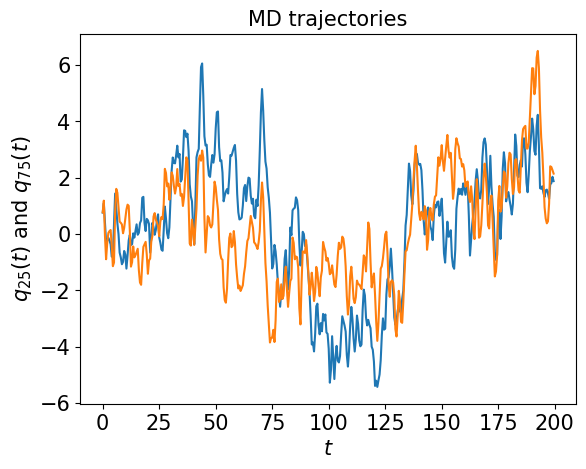

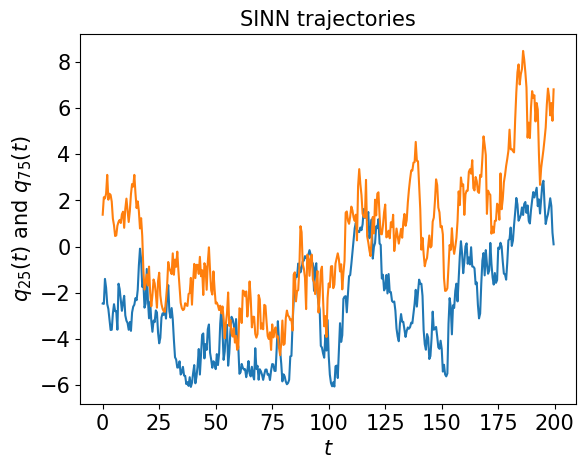

In [37]:
test1(model)

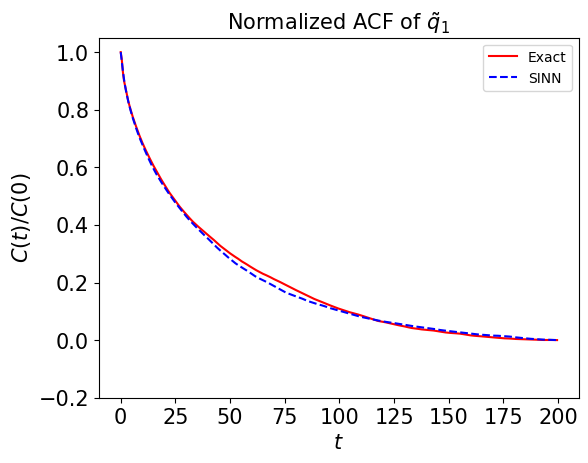

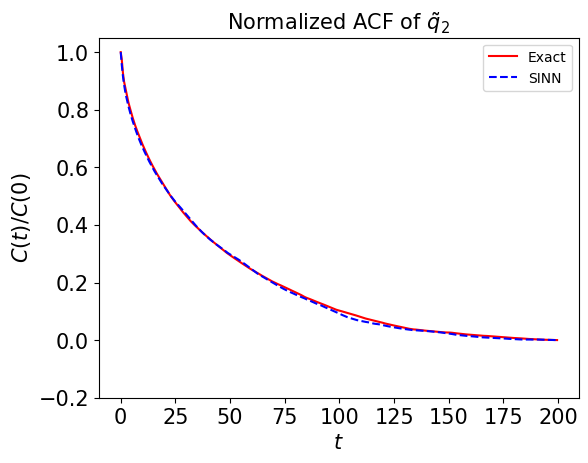

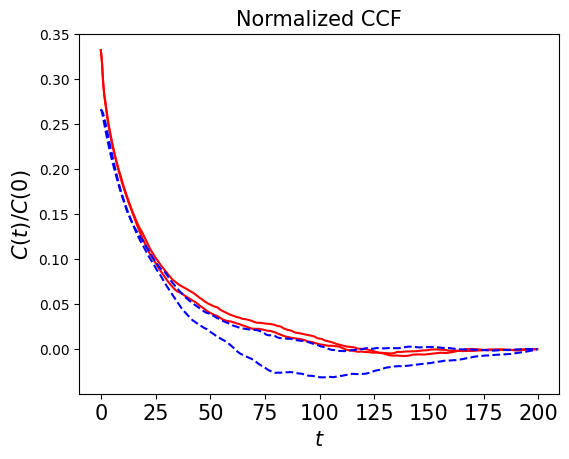

In [38]:
test2(model)

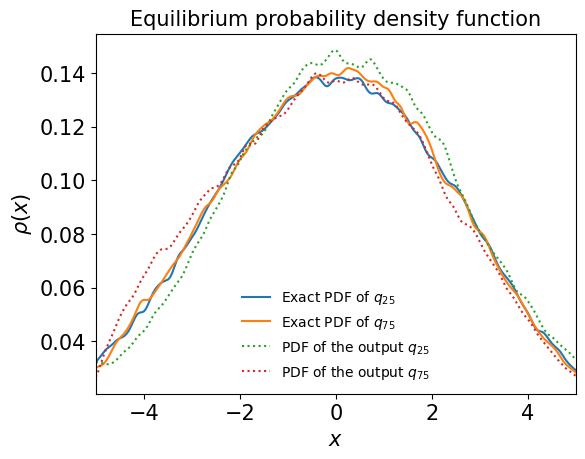

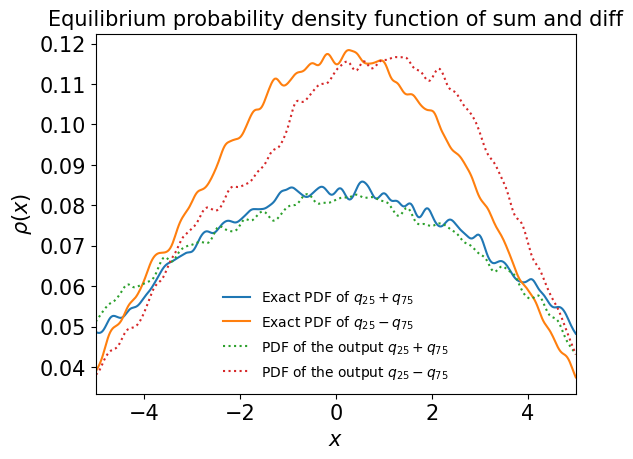

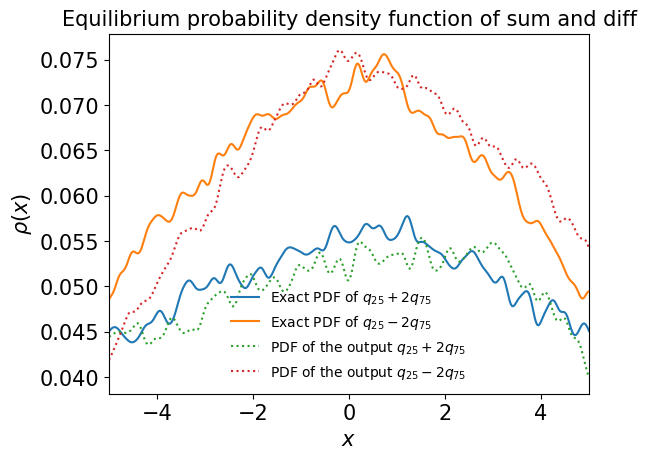

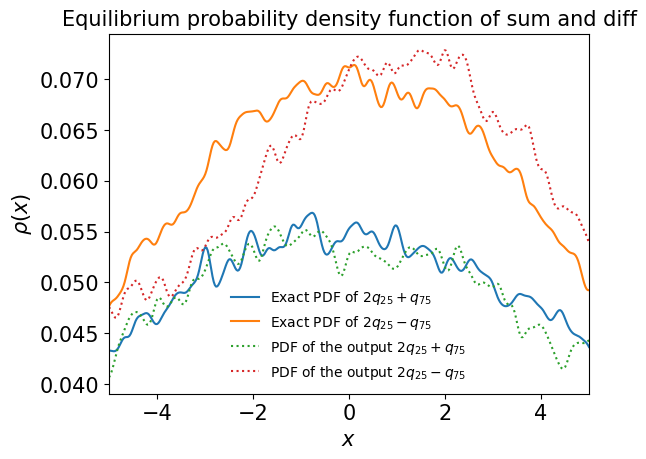

In [39]:
test3(model)

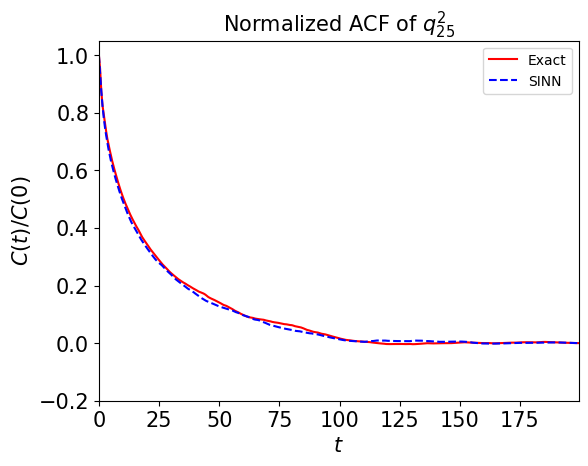

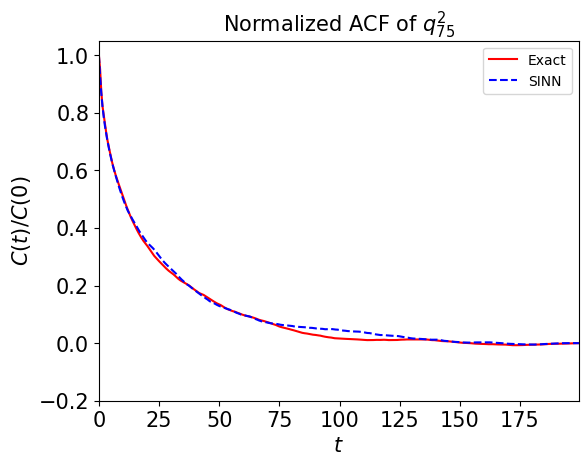

In [40]:
test4(model)

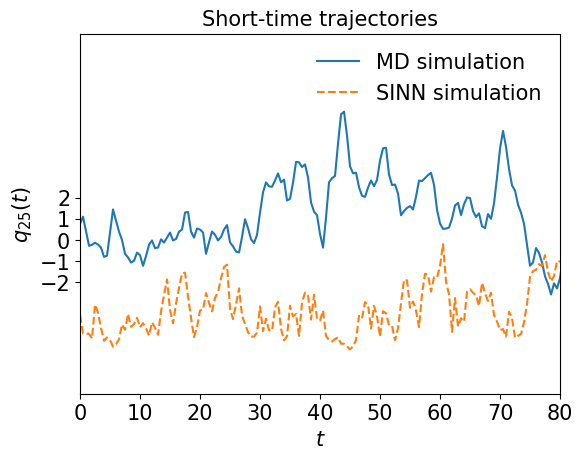

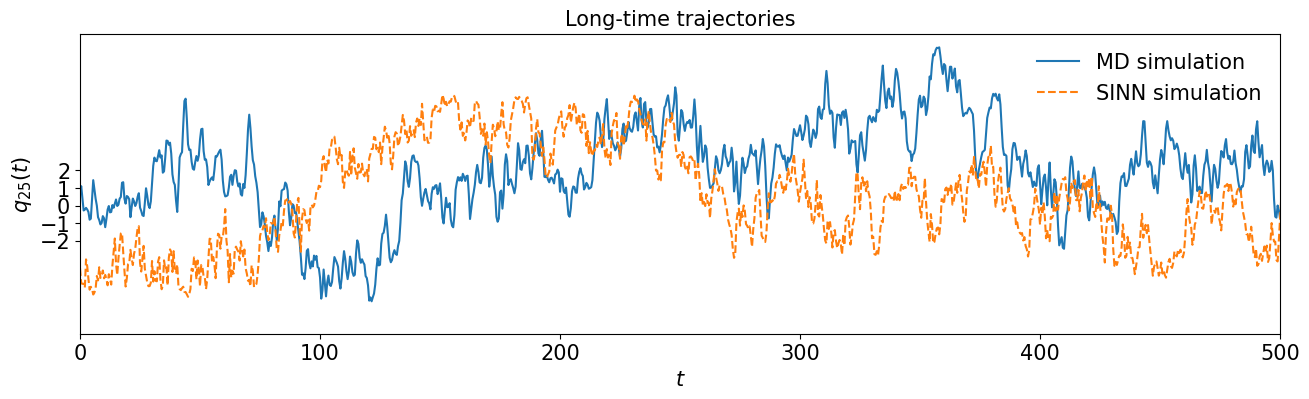

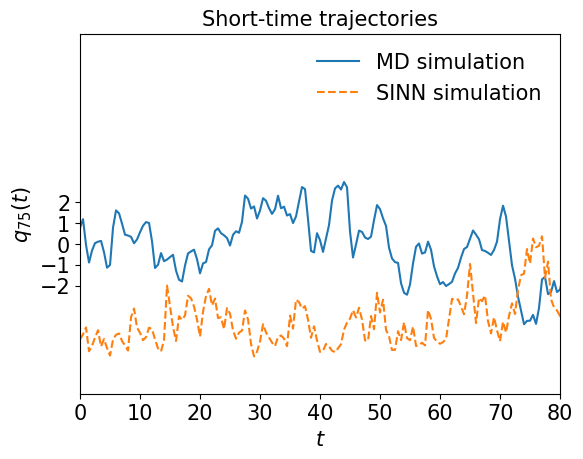

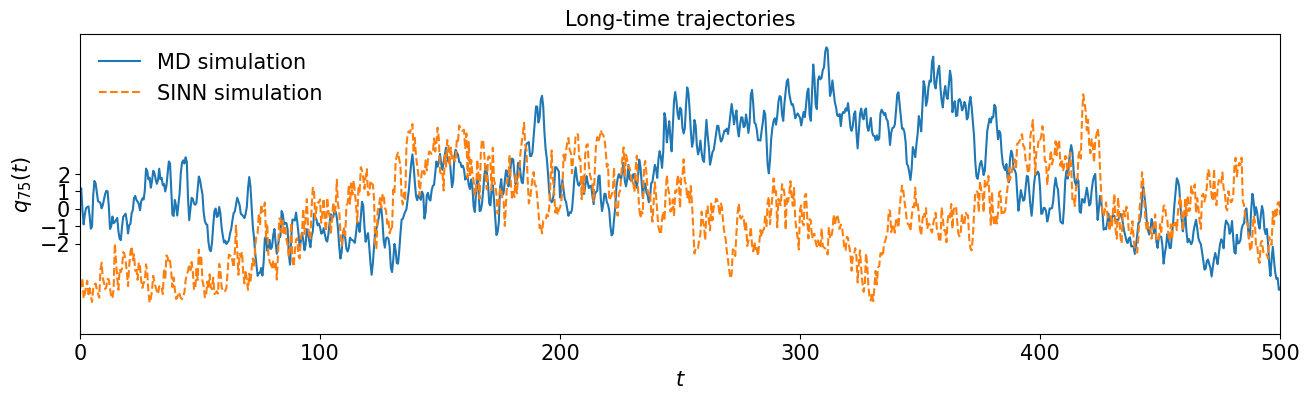

In [41]:
test5(model)

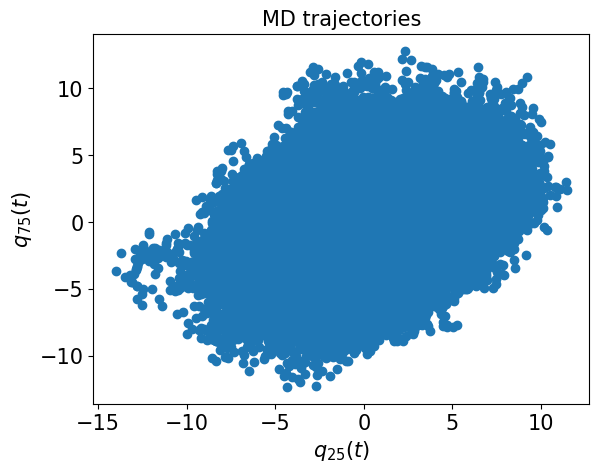

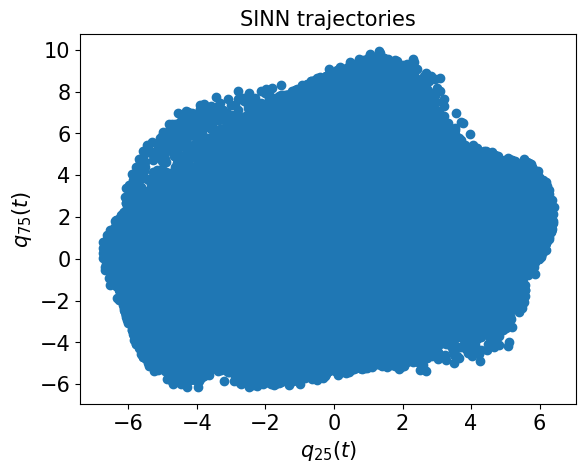

In [42]:
test6(model)

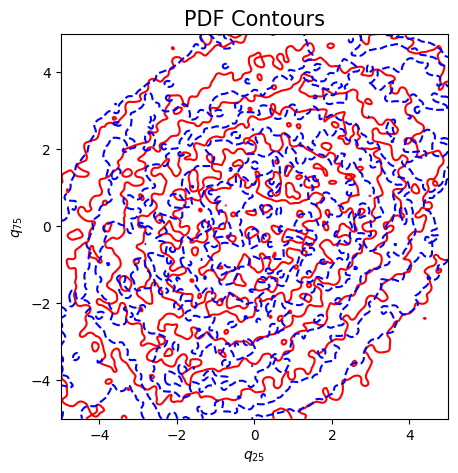

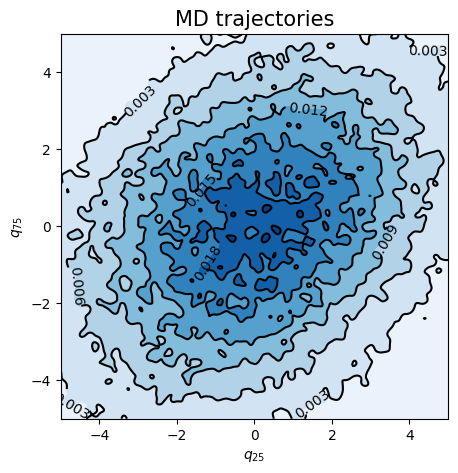

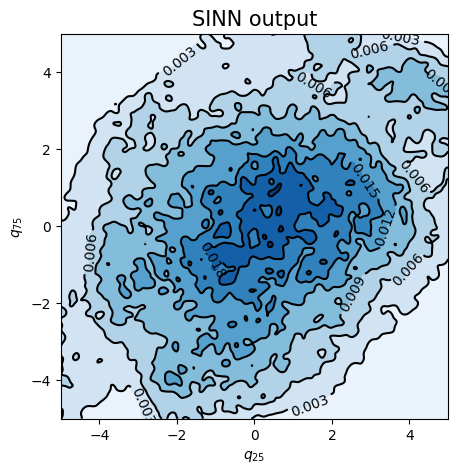

In [43]:
test7(model)

In [44]:
### Defining SINN model
net1 = SINN(2, 50, 2, 2,'LSTM').to(device) # input dimension, hidden size, number of layers, output dimension
model1 = Model(net=net1)
model1.train()

[0]-th step loss: 0.7069, 0.7004, acf: 0.07753, ccf: 0.00621, pdf: 0.28990, pdf2: 0.29350, acf2: 0.03327
[50]-th step loss: 0.0847, 0.0840, acf: 0.01185, ccf: 0.02829, pdf: 0.02686, pdf2: 0.01412, acf2: 0.00293
[100]-th step loss: 0.0183, 0.0203, acf: 0.00588, ccf: 0.00100, pdf: 0.00622, pdf2: 0.00286, acf2: 0.00437
[150]-th step loss: 0.0270, 0.0276, acf: 0.01778, ccf: 0.00123, pdf: 0.00499, pdf2: 0.00211, acf2: 0.00148
[200]-th step loss: 0.0169, 0.0155, acf: 0.00672, ccf: 0.00047, pdf: 0.00477, pdf2: 0.00163, acf2: 0.00195
[250]-th step loss: 0.0071, 0.0083, acf: 0.00226, ccf: 0.00143, pdf: 0.00281, pdf2: 0.00097, acf2: 0.00079
[300]-th step loss: 0.0086, 0.0084, acf: 0.00160, ccf: 0.00162, pdf: 0.00310, pdf2: 0.00059, acf2: 0.00146
[350]-th step loss: 0.0061, 0.0056, acf: 0.00146, ccf: 0.00066, pdf: 0.00150, pdf2: 0.00052, acf2: 0.00146
[400]-th step loss: 0.0052, 0.0060, acf: 0.00038, ccf: 0.00126, pdf: 0.00156, pdf2: 0.00056, acf2: 0.00226
[450]-th step loss: 0.0037, 0.0046, acf:

[3850]-th step loss: 0.0021, 0.0023, acf: 0.00064, ccf: 0.00046, pdf: 0.00010, pdf2: 0.00008, acf2: 0.00102
[3900]-th step loss: 0.0032, 0.0023, acf: 0.00061, ccf: 0.00068, pdf: 0.00005, pdf2: 0.00004, acf2: 0.00092
[3950]-th step loss: 0.0012, 0.0016, acf: 0.00041, ccf: 0.00067, pdf: 0.00006, pdf2: 0.00004, acf2: 0.00047
[4000]-th step loss: 0.0027, 0.0008, acf: 0.00025, ccf: 0.00014, pdf: 0.00007, pdf2: 0.00003, acf2: 0.00027
[4050]-th step loss: 0.0012, 0.0012, acf: 0.00061, ccf: 0.00027, pdf: 0.00005, pdf2: 0.00005, acf2: 0.00020
[4100]-th step loss: 0.0011, 0.0014, acf: 0.00078, ccf: 0.00017, pdf: 0.00006, pdf2: 0.00004, acf2: 0.00038
[4150]-th step loss: 0.0041, 0.0031, acf: 0.00040, ccf: 0.00065, pdf: 0.00039, pdf2: 0.00021, acf2: 0.00140
[4200]-th step loss: 0.0016, 0.0018, acf: 0.00056, ccf: 0.00048, pdf: 0.00004, pdf2: 0.00003, acf2: 0.00068
[4250]-th step loss: 0.0015, 0.0019, acf: 0.00013, ccf: 0.00108, pdf: 0.00012, pdf2: 0.00005, acf2: 0.00056
[4300]-th step loss: 0.0017,

[7650]-th step loss: 0.0006, 0.0017, acf: 0.00061, ccf: 0.00088, pdf: 0.00002, pdf2: 0.00001, acf2: 0.00020
[7700]-th step loss: 0.0008, 0.0014, acf: 0.00059, ccf: 0.00066, pdf: 0.00003, pdf2: 0.00001, acf2: 0.00012
[7750]-th step loss: 0.0013, 0.0016, acf: 0.00007, ccf: 0.00097, pdf: 0.00008, pdf2: 0.00005, acf2: 0.00043
[7800]-th step loss: 0.0039, 0.0025, acf: 0.00078, ccf: 0.00135, pdf: 0.00003, pdf2: 0.00001, acf2: 0.00031
[7850]-th step loss: 0.0018, 0.0018, acf: 0.00094, ccf: 0.00041, pdf: 0.00004, pdf2: 0.00003, acf2: 0.00042
[7900]-th step loss: 0.0012, 0.0018, acf: 0.00088, ccf: 0.00058, pdf: 0.00006, pdf2: 0.00002, acf2: 0.00025
[7950]-th step loss: 0.0012, 0.0016, acf: 0.00075, ccf: 0.00056, pdf: 0.00005, pdf2: 0.00002, acf2: 0.00025
[8000]-th step loss: 0.0038, 0.0044, acf: 0.00123, ccf: 0.00109, pdf: 0.00149, pdf2: 0.00037, acf2: 0.00027
[8050]-th step loss: 0.0017, 0.0027, acf: 0.00072, ccf: 0.00126, pdf: 0.00041, pdf2: 0.00014, acf2: 0.00018
[8100]-th step loss: 0.0014,

[11450]-th step loss: 0.0311, 0.0296, acf: 0.02193, ccf: 0.00021, pdf: 0.00004, pdf2: 0.00002, acf2: 0.00739
[11500]-th step loss: 0.0395, 0.0313, acf: 0.02456, ccf: 0.00018, pdf: 0.00001, pdf2: 0.00001, acf2: 0.00655
[11550]-th step loss: 0.0293, 0.0298, acf: 0.02253, ccf: 0.00017, pdf: 0.00001, pdf2: 0.00000, acf2: 0.00710
[11600]-th step loss: 0.0329, 0.0288, acf: 0.02104, ccf: 0.00017, pdf: 0.00001, pdf2: 0.00000, acf2: 0.00758
[11650]-th step loss: 0.0285, 0.0287, acf: 0.02152, ccf: 0.00016, pdf: 0.00003, pdf2: 0.00001, acf2: 0.00702
[11700]-th step loss: 0.0329, 0.0284, acf: 0.02125, ccf: 0.00013, pdf: 0.00002, pdf2: 0.00001, acf2: 0.00698
[11750]-th step loss: 0.0451, 0.0319, acf: 0.02440, ccf: 0.00018, pdf: 0.00007, pdf2: 0.00002, acf2: 0.00719
[11800]-th step loss: 0.0322, 0.0301, acf: 0.02233, ccf: 0.00015, pdf: 0.00003, pdf2: 0.00001, acf2: 0.00763
[11850]-th step loss: 0.0343, 0.0294, acf: 0.02222, ccf: 0.00010, pdf: 0.00003, pdf2: 0.00001, acf2: 0.00708
[11900]-th step los

[15250]-th step loss: 0.0283, 0.0275, acf: 0.02487, ccf: 0.00003, pdf: 0.00001, pdf2: 0.00000, acf2: 0.00254
[15300]-th step loss: 0.0438, 0.0422, acf: 0.03273, ccf: 0.00004, pdf: 0.00000, pdf2: 0.00000, acf2: 0.00940
[15350]-th step loss: 0.0251, 0.0255, acf: 0.02207, ccf: 0.00004, pdf: 0.00001, pdf2: 0.00000, acf2: 0.00335
[15400]-th step loss: 0.0252, 0.0273, acf: 0.02435, ccf: 0.00006, pdf: 0.00001, pdf2: 0.00000, acf2: 0.00290
[15450]-th step loss: 0.0290, 0.0259, acf: 0.02293, ccf: 0.00006, pdf: 0.00000, pdf2: 0.00000, acf2: 0.00287
[15500]-th step loss: 0.0274, 0.0314, acf: 0.02842, ccf: 0.00004, pdf: 0.00001, pdf2: 0.00000, acf2: 0.00292
[15550]-th step loss: 0.0361, 0.0310, acf: 0.02808, ccf: 0.00003, pdf: 0.00001, pdf2: 0.00000, acf2: 0.00283
[15600]-th step loss: 0.0380, 0.0280, acf: 0.02640, ccf: 0.00004, pdf: 0.00001, pdf2: 0.00000, acf2: 0.00159
[15650]-th step loss: 0.0287, 0.0268, acf: 0.02400, ccf: 0.00003, pdf: 0.00001, pdf2: 0.00000, acf2: 0.00272
[15700]-th step los

[19050]-th step loss: 0.0343, 0.0400, acf: 0.03436, ccf: 0.00005, pdf: 0.00001, pdf2: 0.00000, acf2: 0.00558
[19100]-th step loss: 0.0359, 0.0354, acf: 0.03145, ccf: 0.00004, pdf: 0.00001, pdf2: 0.00000, acf2: 0.00394
[19150]-th step loss: 0.0307, 0.0336, acf: 0.03078, ccf: 0.00003, pdf: 0.00000, pdf2: 0.00000, acf2: 0.00277
[19200]-th step loss: 0.0290, 0.0299, acf: 0.02813, ccf: 0.00005, pdf: 0.00001, pdf2: 0.00000, acf2: 0.00175
[19250]-th step loss: 0.0534, 0.0535, acf: 0.03899, ccf: 0.00039, pdf: 0.00017, pdf2: 0.00002, acf2: 0.01394
[19300]-th step loss: 0.0554, 0.0597, acf: 0.04466, ccf: 0.00011, pdf: 0.00007, pdf2: 0.00001, acf2: 0.01484
[19350]-th step loss: 0.0680, 0.0595, acf: 0.04383, ccf: 0.00006, pdf: 0.00004, pdf2: 0.00000, acf2: 0.01559
[19400]-th step loss: 0.0607, 0.0643, acf: 0.04662, ccf: 0.00004, pdf: 0.00002, pdf2: 0.00001, acf2: 0.01758
[19450]-th step loss: 0.0671, 0.0637, acf: 0.04612, ccf: 0.00003, pdf: 0.00002, pdf2: 0.00001, acf2: 0.01749
[19500]-th step los

In [45]:
### Defining SINN model
net2 = SINN(2, 50, 2, 2,'LSTM').to(device) # input dimension, hidden size, number of layers, output dimension
model2 = Model(net=net2)
model2.train()

[0]-th step loss: 0.7025, 0.6993, acf: 0.07507, ccf: 0.00441, pdf: 0.29094, pdf2: 0.29757, acf2: 0.03128
[50]-th step loss: 0.0970, 0.0967, acf: 0.02961, ccf: 0.01382, pdf: 0.02862, pdf2: 0.01810, acf2: 0.00652
[100]-th step loss: 0.0581, 0.0588, acf: 0.01686, ccf: 0.00451, pdf: 0.02525, pdf2: 0.01114, acf2: 0.00105
[150]-th step loss: 0.0291, 0.0259, acf: 0.00329, ccf: 0.00296, pdf: 0.00910, pdf2: 0.00721, acf2: 0.00338
[200]-th step loss: 0.0985, 0.1050, acf: 0.02868, ccf: 0.01833, pdf: 0.02727, pdf2: 0.02280, acf2: 0.00793
[250]-th step loss: 0.0585, 0.0571, acf: 0.01191, ccf: 0.02304, pdf: 0.01244, pdf2: 0.00691, acf2: 0.00280
[300]-th step loss: 0.0274, 0.0306, acf: 0.00408, ccf: 0.01202, pdf: 0.00766, pdf2: 0.00543, acf2: 0.00135
[350]-th step loss: 0.0361, 0.0351, acf: 0.01448, ccf: 0.00703, pdf: 0.01054, pdf2: 0.00186, acf2: 0.00117
[400]-th step loss: 0.0135, 0.0824, acf: 0.01088, ccf: 0.01814, pdf: 0.02669, pdf2: 0.00245, acf2: 0.02426
[450]-th step loss: 0.0124, 0.0113, acf:

[3850]-th step loss: 0.0211, 0.0227, acf: 0.01593, ccf: 0.00018, pdf: 0.00457, pdf2: 0.00188, acf2: 0.00019
[3900]-th step loss: 0.0193, 0.0214, acf: 0.01495, ccf: 0.00007, pdf: 0.00444, pdf2: 0.00179, acf2: 0.00012
[3950]-th step loss: 0.0206, 0.0206, acf: 0.01434, ccf: 0.00005, pdf: 0.00434, pdf2: 0.00171, acf2: 0.00011
[4000]-th step loss: 0.0202, 0.0204, acf: 0.01335, ccf: 0.00039, pdf: 0.00505, pdf2: 0.00145, acf2: 0.00017
[4050]-th step loss: 0.0505, 0.0533, acf: 0.03488, ccf: 0.00357, pdf: 0.00228, pdf2: 0.00108, acf2: 0.01153
[4100]-th step loss: 0.0522, 0.0514, acf: 0.03471, ccf: 0.00322, pdf: 0.00191, pdf2: 0.00084, acf2: 0.01069
[4150]-th step loss: 0.0537, 0.0506, acf: 0.03527, ccf: 0.00258, pdf: 0.00174, pdf2: 0.00071, acf2: 0.01031
[4200]-th step loss: 0.0495, 0.0503, acf: 0.03602, ccf: 0.00189, pdf: 0.00162, pdf2: 0.00061, acf2: 0.01012
[4250]-th step loss: 0.0497, 0.0511, acf: 0.03764, ccf: 0.00121, pdf: 0.00147, pdf2: 0.00051, acf2: 0.01028
[4300]-th step loss: 0.0516,

[7650]-th step loss: 0.0430, 0.0430, acf: 0.02799, ccf: 0.00320, pdf: 0.00204, pdf2: 0.00023, acf2: 0.00958
[7700]-th step loss: 0.0424, 0.0418, acf: 0.02722, ccf: 0.00318, pdf: 0.00172, pdf2: 0.00013, acf2: 0.00956
[7750]-th step loss: 0.0394, 0.0377, acf: 0.02442, ccf: 0.00346, pdf: 0.00156, pdf2: 0.00004, acf2: 0.00819
[7800]-th step loss: 0.0266, 0.0266, acf: 0.01830, ccf: 0.00328, pdf: 0.00116, pdf2: 0.00004, acf2: 0.00387
[7850]-th step loss: 0.0167, 0.0156, acf: 0.00889, ccf: 0.00461, pdf: 0.00155, pdf2: 0.00004, acf2: 0.00056
[7900]-th step loss: 0.0120, 0.0121, acf: 0.00486, ccf: 0.00385, pdf: 0.00159, pdf2: 0.00007, acf2: 0.00168
[7950]-th step loss: 0.0088, 0.0096, acf: 0.00302, ccf: 0.00476, pdf: 0.00111, pdf2: 0.00005, acf2: 0.00068
[8000]-th step loss: 0.0117, 0.0100, acf: 0.00192, ccf: 0.00596, pdf: 0.00136, pdf2: 0.00010, acf2: 0.00068
[8050]-th step loss: 0.0105, 0.0091, acf: 0.00234, ccf: 0.00581, pdf: 0.00060, pdf2: 0.00005, acf2: 0.00035
[8100]-th step loss: 0.0085,

[11450]-th step loss: 0.0011, 0.0016, acf: 0.00053, ccf: 0.00077, pdf: 0.00008, pdf2: 0.00004, acf2: 0.00016
[11500]-th step loss: 0.0024, 0.0021, acf: 0.00053, ccf: 0.00137, pdf: 0.00005, pdf2: 0.00001, acf2: 0.00016
[11550]-th step loss: 0.0010, 0.0011, acf: 0.00046, ccf: 0.00044, pdf: 0.00003, pdf2: 0.00001, acf2: 0.00018
[11600]-th step loss: 0.0013, 0.0013, acf: 0.00029, ccf: 0.00073, pdf: 0.00005, pdf2: 0.00001, acf2: 0.00016
[11650]-th step loss: 0.0020, 0.0012, acf: 0.00059, ccf: 0.00041, pdf: 0.00006, pdf2: 0.00001, acf2: 0.00012
[11700]-th step loss: 0.0007, 0.0014, acf: 0.00048, ccf: 0.00061, pdf: 0.00008, pdf2: 0.00003, acf2: 0.00016
[11750]-th step loss: 0.0016, 0.0009, acf: 0.00051, ccf: 0.00018, pdf: 0.00004, pdf2: 0.00002, acf2: 0.00016
[11800]-th step loss: 0.0016, 0.0029, acf: 0.00060, ccf: 0.00203, pdf: 0.00009, pdf2: 0.00003, acf2: 0.00019
[11850]-th step loss: 0.0007, 0.0010, acf: 0.00022, ccf: 0.00039, pdf: 0.00006, pdf2: 0.00001, acf2: 0.00027
[11900]-th step los

[15250]-th step loss: 0.0227, 0.0232, acf: 0.00471, ccf: 0.00516, pdf: 0.00663, pdf2: 0.00258, acf2: 0.00407
[15300]-th step loss: 0.0148, 0.0137, acf: 0.00252, ccf: 0.00153, pdf: 0.00592, pdf2: 0.00217, acf2: 0.00153
[15350]-th step loss: 0.0074, 0.0072, acf: 0.00032, ccf: 0.00071, pdf: 0.00396, pdf2: 0.00160, acf2: 0.00061
[15400]-th step loss: 0.0049, 0.0056, acf: 0.00045, ccf: 0.00079, pdf: 0.00293, pdf2: 0.00105, acf2: 0.00038
[15450]-th step loss: 0.0051, 0.0048, acf: 0.00048, ccf: 0.00051, pdf: 0.00255, pdf2: 0.00079, acf2: 0.00045
[15500]-th step loss: 0.0052, 0.0037, acf: 0.00031, ccf: 0.00024, pdf: 0.00223, pdf2: 0.00068, acf2: 0.00024
[15550]-th step loss: 0.0026, 0.0039, acf: 0.00096, ccf: 0.00051, pdf: 0.00147, pdf2: 0.00046, acf2: 0.00055
[15600]-th step loss: 0.0037, 0.0038, acf: 0.00066, ccf: 0.00055, pdf: 0.00151, pdf2: 0.00047, acf2: 0.00055
[15650]-th step loss: 0.0028, 0.0026, acf: 0.00027, ccf: 0.00049, pdf: 0.00098, pdf2: 0.00038, acf2: 0.00046
[15700]-th step los

[19050]-th step loss: 0.0470, 0.0452, acf: 0.03058, ccf: 0.00005, pdf: 0.00001, pdf2: 0.00000, acf2: 0.01453
[19100]-th step loss: 0.0443, 0.0441, acf: 0.02930, ccf: 0.00009, pdf: 0.00010, pdf2: 0.00002, acf2: 0.01461
[19150]-th step loss: 0.0415, 0.0443, acf: 0.03099, ccf: 0.00005, pdf: 0.00004, pdf2: 0.00001, acf2: 0.01320
[19200]-th step loss: 0.0414, 0.0414, acf: 0.02993, ccf: 0.00005, pdf: 0.00001, pdf2: 0.00000, acf2: 0.01142
[19250]-th step loss: 0.0395, 0.0381, acf: 0.02826, ccf: 0.00006, pdf: 0.00002, pdf2: 0.00001, acf2: 0.00978
[19300]-th step loss: 0.0429, 0.0424, acf: 0.03221, ccf: 0.00010, pdf: 0.00002, pdf2: 0.00001, acf2: 0.01002
[19350]-th step loss: 0.0382, 0.0405, acf: 0.03092, ccf: 0.00007, pdf: 0.00004, pdf2: 0.00001, acf2: 0.00948
[19400]-th step loss: 0.0396, 0.0421, acf: 0.03231, ccf: 0.00006, pdf: 0.00005, pdf2: 0.00001, acf2: 0.00963
[19450]-th step loss: 0.0433, 0.0425, acf: 0.03219, ccf: 0.00007, pdf: 0.00002, pdf2: 0.00000, acf2: 0.01026
[19500]-th step los

In [46]:
### Defining SINN model
net3 = SINN(2, 50, 2, 2,'LSTM').to(device) # input dimension, hidden size, number of layers, output dimension
model3 = Model(net=net3)
model3.train()

[0]-th step loss: 0.7153, 0.7104, acf: 0.07683, ccf: 0.01483, pdf: 0.29040, pdf2: 0.29562, acf2: 0.03267
[50]-th step loss: 0.2486, 0.2380, acf: 0.02998, ccf: 0.01791, pdf: 0.12325, pdf2: 0.05448, acf2: 0.01235
[100]-th step loss: 0.0689, 0.0712, acf: 0.01396, ccf: 0.02364, pdf: 0.01698, pdf2: 0.01195, acf2: 0.00467
[150]-th step loss: 0.0815, 0.0773, acf: 0.00354, ccf: 0.02357, pdf: 0.03242, pdf2: 0.01554, acf2: 0.00222
[200]-th step loss: 0.0410, 0.0483, acf: 0.00162, ccf: 0.03566, pdf: 0.00681, pdf2: 0.00332, acf2: 0.00094
[250]-th step loss: 0.0441, 0.0412, acf: 0.00709, ccf: 0.01187, pdf: 0.01205, pdf2: 0.00724, acf2: 0.00297
[300]-th step loss: 0.0662, 0.0556, acf: 0.02460, ccf: 0.00129, pdf: 0.02115, pdf2: 0.00644, acf2: 0.00213
[350]-th step loss: 0.0762, 0.0826, acf: 0.02840, ccf: 0.00146, pdf: 0.03709, pdf2: 0.00947, acf2: 0.00614
[400]-th step loss: 0.0454, 0.0382, acf: 0.02611, ccf: 0.00095, pdf: 0.00703, pdf2: 0.00316, acf2: 0.00096
[450]-th step loss: 0.0131, 0.0150, acf:

[3850]-th step loss: 0.0145, 0.0122, acf: 0.00044, ccf: 0.00436, pdf: 0.00525, pdf2: 0.00167, acf2: 0.00052
[3900]-th step loss: 0.0082, 0.0087, acf: 0.00036, ccf: 0.00066, pdf: 0.00521, pdf2: 0.00184, acf2: 0.00060
[3950]-th step loss: 0.0155, 0.0136, acf: 0.00075, ccf: 0.00550, pdf: 0.00519, pdf2: 0.00166, acf2: 0.00049
[4000]-th step loss: 0.0079, 0.0096, acf: 0.00084, ccf: 0.00080, pdf: 0.00560, pdf2: 0.00180, acf2: 0.00054
[4050]-th step loss: 0.0080, 0.0084, acf: 0.00045, ccf: 0.00033, pdf: 0.00541, pdf2: 0.00187, acf2: 0.00032
[4100]-th step loss: 0.0082, 0.0081, acf: 0.00035, ccf: 0.00027, pdf: 0.00546, pdf2: 0.00178, acf2: 0.00027
[4150]-th step loss: 0.0077, 0.0082, acf: 0.00043, ccf: 0.00037, pdf: 0.00546, pdf2: 0.00180, acf2: 0.00012
[4200]-th step loss: 0.0095, 0.0085, acf: 0.00042, ccf: 0.00047, pdf: 0.00541, pdf2: 0.00193, acf2: 0.00032
[4250]-th step loss: 0.1902, 0.1936, acf: 0.05238, ccf: 0.00221, pdf: 0.09342, pdf2: 0.01635, acf2: 0.02920
[4300]-th step loss: 0.0304,

[7650]-th step loss: 0.0010, 0.0007, acf: 0.00024, ccf: 0.00024, pdf: 0.00009, pdf2: 0.00003, acf2: 0.00009
[7700]-th step loss: 0.0016, 0.0006, acf: 0.00022, ccf: 0.00027, pdf: 0.00001, pdf2: 0.00001, acf2: 0.00013
[7750]-th step loss: 0.0009, 0.0011, acf: 0.00024, ccf: 0.00068, pdf: 0.00003, pdf2: 0.00002, acf2: 0.00007
[7800]-th step loss: 0.0005, 0.0006, acf: 0.00014, ccf: 0.00031, pdf: 0.00001, pdf2: 0.00001, acf2: 0.00008
[7850]-th step loss: 0.0007, 0.0009, acf: 0.00019, ccf: 0.00056, pdf: 0.00007, pdf2: 0.00002, acf2: 0.00005
[7900]-th step loss: 0.0005, 0.0007, acf: 0.00015, ccf: 0.00024, pdf: 0.00011, pdf2: 0.00003, acf2: 0.00016
[7950]-th step loss: 0.0005, 0.0006, acf: 0.00017, ccf: 0.00028, pdf: 0.00004, pdf2: 0.00002, acf2: 0.00008
[8000]-th step loss: 0.0004, 0.0006, acf: 0.00026, ccf: 0.00012, pdf: 0.00007, pdf2: 0.00003, acf2: 0.00010
[8050]-th step loss: 0.0004, 0.0003, acf: 0.00006, ccf: 0.00009, pdf: 0.00002, pdf2: 0.00001, acf2: 0.00013
Training finished
Training t

In [47]:
### Defining SINN model
net4 = SINN(2, 50, 2, 2,'LSTM').to(device) # input dimension, hidden size, number of layers, output dimension
model4 = Model(net=net4)
model4.train()

[0]-th step loss: 0.7110, 0.6999, acf: 0.07562, ccf: 0.00445, pdf: 0.29085, pdf2: 0.29732, acf2: 0.03170
[50]-th step loss: 0.1123, 0.1168, acf: 0.02182, ccf: 0.02604, pdf: 0.04291, pdf2: 0.02314, acf2: 0.00294
[100]-th step loss: 0.0630, 0.0617, acf: 0.02270, ccf: 0.01731, pdf: 0.01401, pdf2: 0.00714, acf2: 0.00059
[150]-th step loss: 0.0542, 0.0562, acf: 0.02349, ccf: 0.01633, pdf: 0.01015, pdf2: 0.00571, acf2: 0.00054
[200]-th step loss: 0.0649, 0.0643, acf: 0.00367, ccf: 0.03357, pdf: 0.01071, pdf2: 0.00505, acf2: 0.01130
[250]-th step loss: 0.0500, 0.0554, acf: 0.00617, ccf: 0.02904, pdf: 0.01125, pdf2: 0.00509, acf2: 0.00388
[300]-th step loss: 0.0630, 0.0700, acf: 0.02940, ccf: 0.01037, pdf: 0.01008, pdf2: 0.01679, acf2: 0.00338
[350]-th step loss: 0.0446, 0.0475, acf: 0.01624, ccf: 0.01789, pdf: 0.00734, pdf2: 0.00411, acf2: 0.00189
[400]-th step loss: 0.0842, 0.0950, acf: 0.04045, ccf: 0.01112, pdf: 0.01743, pdf2: 0.01678, acf2: 0.00920
[450]-th step loss: 0.0490, 0.0546, acf:

[3850]-th step loss: 0.0540, 0.0583, acf: 0.04432, ccf: 0.00017, pdf: 0.00001, pdf2: 0.00001, acf2: 0.01380
[3900]-th step loss: 0.0619, 0.0622, acf: 0.04713, ccf: 0.00026, pdf: 0.00002, pdf2: 0.00001, acf2: 0.01476
[3950]-th step loss: 0.0578, 0.0578, acf: 0.04426, ccf: 0.00016, pdf: 0.00000, pdf2: 0.00000, acf2: 0.01336
[4000]-th step loss: 0.0554, 0.0549, acf: 0.04207, ccf: 0.00014, pdf: 0.00001, pdf2: 0.00000, acf2: 0.01271
[4050]-th step loss: 0.0589, 0.0560, acf: 0.04310, ccf: 0.00014, pdf: 0.00001, pdf2: 0.00000, acf2: 0.01272
[4100]-th step loss: 0.0520, 0.0556, acf: 0.04303, ccf: 0.00014, pdf: 0.00001, pdf2: 0.00000, acf2: 0.01244
[4150]-th step loss: 0.0593, 0.0560, acf: 0.04341, ccf: 0.00013, pdf: 0.00001, pdf2: 0.00000, acf2: 0.01246
[4200]-th step loss: 0.0550, 0.0559, acf: 0.04332, ccf: 0.00013, pdf: 0.00000, pdf2: 0.00000, acf2: 0.01240
[4250]-th step loss: 0.0546, 0.0554, acf: 0.04273, ccf: 0.00013, pdf: 0.00000, pdf2: 0.00000, acf2: 0.01249
[4300]-th step loss: 0.0534,

[7650]-th step loss: 0.0426, 0.0429, acf: 0.04180, ccf: 0.00003, pdf: 0.00001, pdf2: 0.00000, acf2: 0.00108
[7700]-th step loss: 0.0423, 0.0436, acf: 0.04256, ccf: 0.00005, pdf: 0.00002, pdf2: 0.00001, acf2: 0.00100
[7750]-th step loss: 0.0415, 0.0431, acf: 0.04207, ccf: 0.00003, pdf: 0.00001, pdf2: 0.00000, acf2: 0.00095
[7800]-th step loss: 0.0425, 0.0422, acf: 0.04119, ccf: 0.00004, pdf: 0.00001, pdf2: 0.00000, acf2: 0.00094
[7850]-th step loss: 0.0434, 0.0436, acf: 0.04243, ccf: 0.00004, pdf: 0.00001, pdf2: 0.00001, acf2: 0.00106
[7900]-th step loss: 0.0458, 0.0438, acf: 0.04270, ccf: 0.00004, pdf: 0.00001, pdf2: 0.00000, acf2: 0.00102
[7950]-th step loss: 0.0416, 0.0438, acf: 0.04290, ccf: 0.00006, pdf: 0.00001, pdf2: 0.00000, acf2: 0.00081
[8000]-th step loss: 0.0422, 0.0426, acf: 0.04184, ccf: 0.00003, pdf: 0.00000, pdf2: 0.00000, acf2: 0.00073
[8050]-th step loss: 0.0421, 0.0425, acf: 0.04172, ccf: 0.00003, pdf: 0.00001, pdf2: 0.00000, acf2: 0.00070
[8100]-th step loss: 0.0427,

[11450]-th step loss: 0.0436, 0.0406, acf: 0.03914, ccf: 0.00020, pdf: 0.00084, pdf2: 0.00003, acf2: 0.00038
[11500]-th step loss: 0.0432, 0.0418, acf: 0.04069, ccf: 0.00016, pdf: 0.00063, pdf2: 0.00001, acf2: 0.00033
[11550]-th step loss: 0.0420, 0.0422, acf: 0.04078, ccf: 0.00016, pdf: 0.00063, pdf2: 0.00001, acf2: 0.00060
[11600]-th step loss: 0.0367, 0.0375, acf: 0.03629, ccf: 0.00008, pdf: 0.00072, pdf2: 0.00003, acf2: 0.00040
[11650]-th step loss: 0.0456, 0.0432, acf: 0.04226, ccf: 0.00015, pdf: 0.00044, pdf2: 0.00001, acf2: 0.00038
[11700]-th step loss: 0.0390, 0.0396, acf: 0.03737, ccf: 0.00021, pdf: 0.00089, pdf2: 0.00020, acf2: 0.00093
[11750]-th step loss: 0.0409, 0.0379, acf: 0.03669, ccf: 0.00016, pdf: 0.00044, pdf2: 0.00001, acf2: 0.00055
[11800]-th step loss: 0.0355, 0.0354, acf: 0.03442, ccf: 0.00011, pdf: 0.00045, pdf2: 0.00002, acf2: 0.00044
[11850]-th step loss: 0.0459, 0.0417, acf: 0.04008, ccf: 0.00026, pdf: 0.00032, pdf2: 0.00004, acf2: 0.00096
[11900]-th step los

[15250]-th step loss: 0.1276, 0.1273, acf: 0.08263, ccf: 0.00606, pdf: 0.00001, pdf2: 0.00000, acf2: 0.03857
[15300]-th step loss: 0.1272, 0.1275, acf: 0.08272, ccf: 0.00605, pdf: 0.00000, pdf2: 0.00000, acf2: 0.03872
[15350]-th step loss: 0.1276, 0.1276, acf: 0.08285, ccf: 0.00599, pdf: 0.00001, pdf2: 0.00000, acf2: 0.03878
[15400]-th step loss: 0.1278, 0.1276, acf: 0.08289, ccf: 0.00596, pdf: 0.00000, pdf2: 0.00000, acf2: 0.03878
[15450]-th step loss: 0.1277, 0.1276, acf: 0.08288, ccf: 0.00596, pdf: 0.00000, pdf2: 0.00000, acf2: 0.03877
[15500]-th step loss: 0.1277, 0.1275, acf: 0.08282, ccf: 0.00595, pdf: 0.00000, pdf2: 0.00000, acf2: 0.03872
[15550]-th step loss: 0.1275, 0.1275, acf: 0.08286, ccf: 0.00592, pdf: 0.00000, pdf2: 0.00000, acf2: 0.03869
[15600]-th step loss: 0.1276, 0.1275, acf: 0.08289, ccf: 0.00589, pdf: 0.00001, pdf2: 0.00000, acf2: 0.03872
[15650]-th step loss: 0.1277, 0.1274, acf: 0.08285, ccf: 0.00587, pdf: 0.00000, pdf2: 0.00000, acf2: 0.03865
[15700]-th step los

[19050]-th step loss: 0.0326, 0.0351, acf: 0.03241, ccf: 0.00066, pdf: 0.00014, pdf2: 0.00003, acf2: 0.00188
[19100]-th step loss: 0.0480, 0.0403, acf: 0.03689, ccf: 0.00061, pdf: 0.00006, pdf2: 0.00002, acf2: 0.00273
[19150]-th step loss: 0.0362, 0.0417, acf: 0.03897, ccf: 0.00028, pdf: 0.00015, pdf2: 0.00003, acf2: 0.00226
[19200]-th step loss: 0.0348, 0.0472, acf: 0.04333, ccf: 0.00032, pdf: 0.00003, pdf2: 0.00001, acf2: 0.00351
[19250]-th step loss: 0.0443, 0.0438, acf: 0.03477, ccf: 0.00102, pdf: 0.00009, pdf2: 0.00003, acf2: 0.00792
[19300]-th step loss: 0.0545, 0.0655, acf: 0.05265, ccf: 0.00062, pdf: 0.00001, pdf2: 0.00001, acf2: 0.01224
[19350]-th step loss: 0.0492, 0.0501, acf: 0.04416, ccf: 0.00032, pdf: 0.00001, pdf2: 0.00001, acf2: 0.00562
[19400]-th step loss: 0.0613, 0.0535, acf: 0.04664, ccf: 0.00032, pdf: 0.00001, pdf2: 0.00000, acf2: 0.00658
[19450]-th step loss: 0.0382, 0.0365, acf: 0.03075, ccf: 0.00083, pdf: 0.00001, pdf2: 0.00001, acf2: 0.00494
[19500]-th step los

In [48]:
### Defining SINN model
net5 = SINN(2, 50, 2, 2,'LSTM').to(device) # input dimension, hidden size, number of layers, output dimension
model5 = Model(net=net5)
model5.train()

[0]-th step loss: 0.7104, 0.7039, acf: 0.07724, ccf: 0.00620, pdf: 0.29070, pdf2: 0.29671, acf2: 0.03301
[50]-th step loss: 0.0668, 0.0691, acf: 0.01271, ccf: 0.02127, pdf: 0.01893, pdf2: 0.01000, acf2: 0.00618
[100]-th step loss: 0.0835, 0.0838, acf: 0.02166, ccf: 0.02156, pdf: 0.01749, pdf2: 0.01721, acf2: 0.00584
[150]-th step loss: 0.0413, 0.0413, acf: 0.00530, ccf: 0.01918, pdf: 0.01033, pdf2: 0.00470, acf2: 0.00181
[200]-th step loss: 0.0240, 0.0238, acf: 0.00398, ccf: 0.00685, pdf: 0.00768, pdf2: 0.00372, acf2: 0.00157
[250]-th step loss: 0.1054, 0.1042, acf: 0.03678, ccf: 0.03679, pdf: 0.01664, pdf2: 0.00718, acf2: 0.00679
[300]-th step loss: 0.0290, 0.0279, acf: 0.00756, ccf: 0.00246, pdf: 0.00835, pdf2: 0.00460, acf2: 0.00494
[350]-th step loss: 0.1023, 0.1018, acf: 0.04988, ccf: 0.02372, pdf: 0.00986, pdf2: 0.00418, acf2: 0.01411
[400]-th step loss: 0.0380, 0.0287, acf: 0.00849, ccf: 0.00580, pdf: 0.00894, pdf2: 0.00375, acf2: 0.00176
[450]-th step loss: 0.0151, 0.0175, acf:

[3850]-th step loss: 0.0066, 0.0061, acf: 0.00567, ccf: 0.00007, pdf: 0.00014, pdf2: 0.00011, acf2: 0.00008
[3900]-th step loss: 0.0040, 0.0050, acf: 0.00461, ccf: 0.00006, pdf: 0.00012, pdf2: 0.00008, acf2: 0.00010
[3950]-th step loss: 0.0051, 0.0055, acf: 0.00446, ccf: 0.00008, pdf: 0.00009, pdf2: 0.00006, acf2: 0.00077
[4000]-th step loss: 0.0038, 0.0042, acf: 0.00345, ccf: 0.00008, pdf: 0.00006, pdf2: 0.00006, acf2: 0.00051
[4050]-th step loss: 0.0083, 0.0060, acf: 0.00578, ccf: 0.00006, pdf: 0.00002, pdf2: 0.00004, acf2: 0.00010
[4100]-th step loss: 0.0072, 0.0052, acf: 0.00505, ccf: 0.00004, pdf: 0.00002, pdf2: 0.00003, acf2: 0.00010
[4150]-th step loss: 0.0038, 0.0040, acf: 0.00368, ccf: 0.00007, pdf: 0.00001, pdf2: 0.00001, acf2: 0.00019
[4200]-th step loss: 0.0055, 0.0047, acf: 0.00449, ccf: 0.00007, pdf: 0.00002, pdf2: 0.00002, acf2: 0.00013
[4250]-th step loss: 0.0050, 0.0045, acf: 0.00425, ccf: 0.00009, pdf: 0.00001, pdf2: 0.00001, acf2: 0.00013
[4300]-th step loss: 0.0065,

In [49]:
### Defining SINN model
net6 = SINN(2, 50, 2, 2,'LSTM').to(device) # input dimension, hidden size, number of layers, output dimension
model6 = Model(net=net6)
model6.train()

[0]-th step loss: 0.7146, 0.7096, acf: 0.07699, ccf: 0.01339, pdf: 0.29045, pdf2: 0.29589, acf2: 0.03284
[50]-th step loss: 0.0934, 0.0935, acf: 0.02441, ccf: 0.02340, pdf: 0.02060, pdf2: 0.01788, acf2: 0.00721
[100]-th step loss: 0.0234, 0.0288, acf: 0.00631, ccf: 0.00443, pdf: 0.00657, pdf2: 0.00754, acf2: 0.00393
[150]-th step loss: 0.0163, 0.0148, acf: 0.00238, ccf: 0.00586, pdf: 0.00316, pdf2: 0.00275, acf2: 0.00064
[200]-th step loss: 0.0465, 0.0466, acf: 0.01530, ccf: 0.01176, pdf: 0.01270, pdf2: 0.00595, acf2: 0.00091
[250]-th step loss: 0.0804, 0.0770, acf: 0.02959, ccf: 0.01763, pdf: 0.02196, pdf2: 0.00322, acf2: 0.00460
[300]-th step loss: 0.0200, 0.0203, acf: 0.00494, ccf: 0.00182, pdf: 0.00948, pdf2: 0.00244, acf2: 0.00163
[350]-th step loss: 0.0148, 0.0149, acf: 0.00194, ccf: 0.00100, pdf: 0.00763, pdf2: 0.00284, acf2: 0.00149
[400]-th step loss: 0.0205, 0.0194, acf: 0.00840, ccf: 0.00113, pdf: 0.00499, pdf2: 0.00350, acf2: 0.00135
[450]-th step loss: 0.0088, 0.0101, acf:

[3850]-th step loss: 0.0008, 0.0009, acf: 0.00041, ccf: 0.00022, pdf: 0.00005, pdf2: 0.00003, acf2: 0.00020
[3900]-th step loss: 0.0007, 0.0007, acf: 0.00018, ccf: 0.00012, pdf: 0.00008, pdf2: 0.00003, acf2: 0.00030
[3950]-th step loss: 0.0009, 0.0008, acf: 0.00011, ccf: 0.00028, pdf: 0.00012, pdf2: 0.00003, acf2: 0.00022
[4000]-th step loss: 0.0007, 0.0008, acf: 0.00013, ccf: 0.00029, pdf: 0.00011, pdf2: 0.00006, acf2: 0.00016
[4050]-th step loss: 0.0006, 0.0018, acf: 0.00018, ccf: 0.00057, pdf: 0.00049, pdf2: 0.00010, acf2: 0.00044
[4100]-th step loss: 0.0019, 0.0021, acf: 0.00037, ccf: 0.00023, pdf: 0.00051, pdf2: 0.00006, acf2: 0.00092
[4150]-th step loss: 0.0016, 0.0017, acf: 0.00009, ccf: 0.00051, pdf: 0.00063, pdf2: 0.00016, acf2: 0.00026
[4200]-th step loss: 0.0008, 0.0005, acf: 0.00010, ccf: 0.00020, pdf: 0.00008, pdf2: 0.00002, acf2: 0.00013
[4250]-th step loss: 0.0061, 0.0056, acf: 0.00092, ccf: 0.00209, pdf: 0.00178, pdf2: 0.00029, acf2: 0.00055
[4300]-th step loss: 0.0012,

In [50]:
### Defining SINN model
net7 = SINN(2, 50, 2, 2,'LSTM').to(device) # input dimension, hidden size, number of layers, output dimension
model7 = Model(net=net7)
model7.train()

[0]-th step loss: 0.7069, 0.7024, acf: 0.07745, ccf: 0.00461, pdf: 0.29071, pdf2: 0.29636, acf2: 0.03322
[50]-th step loss: 0.0971, 0.0964, acf: 0.02665, ccf: 0.02208, pdf: 0.01771, pdf2: 0.02286, acf2: 0.00709
[100]-th step loss: 0.0470, 0.0465, acf: 0.01710, ccf: 0.01526, pdf: 0.00692, pdf2: 0.00628, acf2: 0.00090
[150]-th step loss: 0.0314, 0.0429, acf: 0.00552, ccf: 0.01041, pdf: 0.01706, pdf2: 0.00770, acf2: 0.00218
[200]-th step loss: 0.0357, 0.0321, acf: 0.01411, ccf: 0.00248, pdf: 0.00941, pdf2: 0.00530, acf2: 0.00080
[250]-th step loss: 0.0591, 0.0483, acf: 0.02274, ccf: 0.00735, pdf: 0.00597, pdf2: 0.00275, acf2: 0.00945
[300]-th step loss: 0.0574, 0.0588, acf: 0.02560, ccf: 0.01347, pdf: 0.00990, pdf2: 0.00273, acf2: 0.00713
[350]-th step loss: 0.1294, 0.1406, acf: 0.04270, ccf: 0.00723, pdf: 0.06306, pdf2: 0.01797, acf2: 0.00958
[400]-th step loss: 0.0512, 0.0542, acf: 0.01638, ccf: 0.01654, pdf: 0.01625, pdf2: 0.00420, acf2: 0.00079
[450]-th step loss: 0.0456, 0.0462, acf:

[3850]-th step loss: 0.0200, 0.0200, acf: 0.01266, ccf: 0.00005, pdf: 0.00520, pdf2: 0.00199, acf2: 0.00014
[3900]-th step loss: 0.0207, 0.0195, acf: 0.01168, ccf: 0.00008, pdf: 0.00578, pdf2: 0.00185, acf2: 0.00011
[3950]-th step loss: 0.0187, 0.0182, acf: 0.01065, ccf: 0.00009, pdf: 0.00516, pdf2: 0.00200, acf2: 0.00035
[4000]-th step loss: 0.0227, 0.0190, acf: 0.01133, ccf: 0.00013, pdf: 0.00550, pdf2: 0.00186, acf2: 0.00016
[4050]-th step loss: 0.0198, 0.0196, acf: 0.01186, ccf: 0.00024, pdf: 0.00496, pdf2: 0.00220, acf2: 0.00031
[4100]-th step loss: 0.0201, 0.0204, acf: 0.01276, ccf: 0.00024, pdf: 0.00515, pdf2: 0.00201, acf2: 0.00028
[4150]-th step loss: 0.0222, 0.0219, acf: 0.01438, ccf: 0.00005, pdf: 0.00509, pdf2: 0.00218, acf2: 0.00025
[4200]-th step loss: 0.0187, 0.0193, acf: 0.01053, ccf: 0.00017, pdf: 0.00638, pdf2: 0.00213, acf2: 0.00009
[4250]-th step loss: 0.0195, 0.0186, acf: 0.01076, ccf: 0.00006, pdf: 0.00579, pdf2: 0.00188, acf2: 0.00012
[4300]-th step loss: 0.0214,

[7650]-th step loss: 0.0137, 0.0136, acf: 0.00472, ccf: 0.00010, pdf: 0.00528, pdf2: 0.00194, acf2: 0.00156
[7700]-th step loss: 0.0140, 0.0138, acf: 0.00472, ccf: 0.00018, pdf: 0.00504, pdf2: 0.00207, acf2: 0.00179
[7750]-th step loss: 0.0156, 0.0160, acf: 0.00840, ccf: 0.00016, pdf: 0.00537, pdf2: 0.00170, acf2: 0.00038
[7800]-th step loss: 0.0168, 0.0153, acf: 0.00772, ccf: 0.00008, pdf: 0.00528, pdf2: 0.00177, acf2: 0.00050
[7850]-th step loss: 0.0161, 0.0149, acf: 0.00738, ccf: 0.00012, pdf: 0.00523, pdf2: 0.00181, acf2: 0.00036
[7900]-th step loss: 0.0167, 0.0153, acf: 0.00788, ccf: 0.00017, pdf: 0.00517, pdf2: 0.00180, acf2: 0.00031
[7950]-th step loss: 0.0154, 0.0158, acf: 0.00855, ccf: 0.00007, pdf: 0.00510, pdf2: 0.00180, acf2: 0.00023
[8000]-th step loss: 0.0154, 0.0174, acf: 0.01016, ccf: 0.00011, pdf: 0.00523, pdf2: 0.00183, acf2: 0.00011
[8050]-th step loss: 0.0168, 0.0171, acf: 0.00964, ccf: 0.00015, pdf: 0.00537, pdf2: 0.00184, acf2: 0.00009
[8100]-th step loss: 0.0198,

[11450]-th step loss: 0.0282, 0.0263, acf: 0.01500, ccf: 0.00021, pdf: 0.00754, pdf2: 0.00249, acf2: 0.00104
[11500]-th step loss: 0.0223, 0.0204, acf: 0.01019, ccf: 0.00009, pdf: 0.00733, pdf2: 0.00224, acf2: 0.00054
[11550]-th step loss: 0.0167, 0.0172, acf: 0.00772, ccf: 0.00011, pdf: 0.00688, pdf2: 0.00192, acf2: 0.00054
[11600]-th step loss: 0.0155, 0.0153, acf: 0.00676, ccf: 0.00007, pdf: 0.00611, pdf2: 0.00144, acf2: 0.00092
[11650]-th step loss: 0.0135, 0.0140, acf: 0.00704, ccf: 0.00009, pdf: 0.00518, pdf2: 0.00110, acf2: 0.00056
[11700]-th step loss: 0.0140, 0.0140, acf: 0.00938, ccf: 0.00021, pdf: 0.00352, pdf2: 0.00075, acf2: 0.00018
[11750]-th step loss: 0.0121, 0.0118, acf: 0.00830, ccf: 0.00006, pdf: 0.00277, pdf2: 0.00049, acf2: 0.00016
[11800]-th step loss: 0.0129, 0.0104, acf: 0.00745, ccf: 0.00007, pdf: 0.00239, pdf2: 0.00037, acf2: 0.00017
[11850]-th step loss: 0.0114, 0.0097, acf: 0.00725, ccf: 0.00008, pdf: 0.00169, pdf2: 0.00026, acf2: 0.00041
[11900]-th step los

[15250]-th step loss: 0.0072, 0.0065, acf: 0.00555, ccf: 0.00032, pdf: 0.00047, pdf2: 0.00001, acf2: 0.00014
[15300]-th step loss: 0.0076, 0.0055, acf: 0.00480, ccf: 0.00020, pdf: 0.00032, pdf2: 0.00001, acf2: 0.00020
[15350]-th step loss: 0.0050, 0.0047, acf: 0.00415, ccf: 0.00026, pdf: 0.00018, pdf2: 0.00001, acf2: 0.00013
[15400]-th step loss: 0.0044, 0.0043, acf: 0.00372, ccf: 0.00018, pdf: 0.00019, pdf2: 0.00002, acf2: 0.00017
[15450]-th step loss: 0.0043, 0.0035, acf: 0.00311, ccf: 0.00016, pdf: 0.00006, pdf2: 0.00002, acf2: 0.00013
[15500]-th step loss: 0.0072, 0.0077, acf: 0.00371, ccf: 0.00085, pdf: 0.00122, pdf2: 0.00045, acf2: 0.00150
[15550]-th step loss: 0.0055, 0.0055, acf: 0.00465, ccf: 0.00021, pdf: 0.00021, pdf2: 0.00004, acf2: 0.00037
[15600]-th step loss: 0.0336, 0.0307, acf: 0.01339, ccf: 0.00043, pdf: 0.00864, pdf2: 0.00404, acf2: 0.00422
[15650]-th step loss: 0.0315, 0.0297, acf: 0.01472, ccf: 0.00055, pdf: 0.00838, pdf2: 0.00346, acf2: 0.00263
[15700]-th step los

[19050]-th step loss: 0.0005, 0.0007, acf: 0.00010, ccf: 0.00020, pdf: 0.00003, pdf2: 0.00002, acf2: 0.00035
[19100]-th step loss: 0.0009, 0.0004, acf: 0.00011, ccf: 0.00007, pdf: 0.00003, pdf2: 0.00002, acf2: 0.00016
[19150]-th step loss: 0.0009, 0.0006, acf: 0.00011, ccf: 0.00016, pdf: 0.00003, pdf2: 0.00001, acf2: 0.00026
[19200]-th step loss: 0.0010, 0.0007, acf: 0.00012, ccf: 0.00017, pdf: 0.00004, pdf2: 0.00002, acf2: 0.00034
[19250]-th step loss: 0.0006, 0.0009, acf: 0.00021, ccf: 0.00030, pdf: 0.00013, pdf2: 0.00003, acf2: 0.00025
[19300]-th step loss: 0.0005, 0.0009, acf: 0.00039, ccf: 0.00012, pdf: 0.00002, pdf2: 0.00001, acf2: 0.00032
[19350]-th step loss: 0.0013, 0.0013, acf: 0.00031, ccf: 0.00009, pdf: 0.00005, pdf2: 0.00004, acf2: 0.00079
[19400]-th step loss: 0.0005, 0.0010, acf: 0.00034, ccf: 0.00032, pdf: 0.00001, pdf2: 0.00001, acf2: 0.00035
[19450]-th step loss: 0.0013, 0.0005, acf: 0.00020, ccf: 0.00010, pdf: 0.00002, pdf2: 0.00001, acf2: 0.00020
[19500]-th step los

In [51]:
### Defining SINN model
net8 = SINN(2, 50, 2, 2,'LSTM').to(device) # input dimension, hidden size, number of layers, output dimension
model8 = Model(net=net8)
model8.train()

[0]-th step loss: 0.7127, 0.7023, acf: 0.07618, ccf: 0.00588, pdf: 0.29083, pdf2: 0.29726, acf2: 0.03210
[50]-th step loss: 0.1051, 0.1052, acf: 0.03193, ccf: 0.01901, pdf: 0.02166, pdf2: 0.02319, acf2: 0.00944
[100]-th step loss: 0.0486, 0.0462, acf: 0.01309, ccf: 0.01656, pdf: 0.00776, pdf2: 0.00664, acf2: 0.00214
[150]-th step loss: 0.0915, 0.0847, acf: 0.03382, ccf: 0.01278, pdf: 0.00890, pdf2: 0.00996, acf2: 0.01919
[200]-th step loss: 0.0331, 0.0312, acf: 0.01686, ccf: 0.00031, pdf: 0.00565, pdf2: 0.00442, acf2: 0.00396
[250]-th step loss: 0.1020, 0.1454, acf: 0.05996, ccf: 0.00655, pdf: 0.03656, pdf2: 0.02001, acf2: 0.02231
[300]-th step loss: 0.0313, 0.0295, acf: 0.00808, ccf: 0.01215, pdf: 0.00648, pdf2: 0.00203, acf2: 0.00077
[350]-th step loss: 0.0719, 0.0653, acf: 0.00868, ccf: 0.02108, pdf: 0.02327, pdf2: 0.00488, acf2: 0.00738
[400]-th step loss: 0.0561, 0.0517, acf: 0.01418, ccf: 0.01693, pdf: 0.01244, pdf2: 0.00290, acf2: 0.00525
[450]-th step loss: 0.0383, 0.0376, acf:

[3850]-th step loss: 0.0426, 0.0429, acf: 0.02668, ccf: 0.00253, pdf: 0.00742, pdf2: 0.00219, acf2: 0.00408
[3900]-th step loss: 0.0252, 0.0286, acf: 0.01753, ccf: 0.00023, pdf: 0.00742, pdf2: 0.00218, acf2: 0.00120
[3950]-th step loss: 0.0380, 0.0369, acf: 0.02439, ccf: 0.00009, pdf: 0.00759, pdf2: 0.00236, acf2: 0.00248
[4000]-th step loss: 0.0381, 0.0390, acf: 0.02676, ccf: 0.00021, pdf: 0.00722, pdf2: 0.00205, acf2: 0.00278
[4050]-th step loss: 0.0276, 0.0287, acf: 0.01893, ccf: 0.00012, pdf: 0.00704, pdf2: 0.00196, acf2: 0.00066
[4100]-th step loss: 0.0253, 0.0218, acf: 0.01240, ccf: 0.00016, pdf: 0.00693, pdf2: 0.00194, acf2: 0.00034
[4150]-th step loss: 0.0229, 0.0241, acf: 0.01503, ccf: 0.00010, pdf: 0.00701, pdf2: 0.00187, acf2: 0.00012
[4200]-th step loss: 0.0281, 0.0284, acf: 0.01636, ccf: 0.00162, pdf: 0.00837, pdf2: 0.00185, acf2: 0.00023
[4250]-th step loss: 0.0232, 0.0237, acf: 0.01489, ccf: 0.00007, pdf: 0.00679, pdf2: 0.00185, acf2: 0.00014
[4300]-th step loss: 0.0205,

[7650]-th step loss: 0.0232, 0.0267, acf: 0.00443, ccf: 0.00593, pdf: 0.00941, pdf2: 0.00305, acf2: 0.00385
[7700]-th step loss: 0.0333, 0.0657, acf: 0.02860, ccf: 0.01383, pdf: 0.00964, pdf2: 0.00436, acf2: 0.00930
[7750]-th step loss: 0.0284, 0.0230, acf: 0.00388, ccf: 0.00135, pdf: 0.00960, pdf2: 0.00503, acf2: 0.00318
[7800]-th step loss: 0.0257, 0.0242, acf: 0.00080, ccf: 0.00104, pdf: 0.00950, pdf2: 0.00394, acf2: 0.00896
[7850]-th step loss: 0.0241, 0.0236, acf: 0.00159, ccf: 0.00315, pdf: 0.00949, pdf2: 0.00377, acf2: 0.00557
[7900]-th step loss: 0.0286, 0.0264, acf: 0.00112, ccf: 0.00408, pdf: 0.00940, pdf2: 0.00336, acf2: 0.00842
[7950]-th step loss: 0.0361, 0.0357, acf: 0.00804, ccf: 0.01285, pdf: 0.00928, pdf2: 0.00327, acf2: 0.00223
[8000]-th step loss: 0.0302, 0.0284, acf: 0.00913, ccf: 0.00540, pdf: 0.00934, pdf2: 0.00341, acf2: 0.00112
[8050]-th step loss: 0.0246, 0.0229, acf: 0.00363, ccf: 0.00430, pdf: 0.00916, pdf2: 0.00357, acf2: 0.00223
[8100]-th step loss: 0.0215,

[11450]-th step loss: 0.0120, 0.0107, acf: 0.00205, ccf: 0.00072, pdf: 0.00552, pdf2: 0.00198, acf2: 0.00046
[11500]-th step loss: 0.0124, 0.0101, acf: 0.00175, ccf: 0.00038, pdf: 0.00566, pdf2: 0.00175, acf2: 0.00054
[11550]-th step loss: 0.0126, 0.0098, acf: 0.00186, ccf: 0.00025, pdf: 0.00537, pdf2: 0.00177, acf2: 0.00051
[11600]-th step loss: 0.0128, 0.0105, acf: 0.00295, ccf: 0.00011, pdf: 0.00547, pdf2: 0.00182, acf2: 0.00014
[11650]-th step loss: 0.0121, 0.0094, acf: 0.00145, ccf: 0.00011, pdf: 0.00545, pdf2: 0.00172, acf2: 0.00065
[11700]-th step loss: 0.0114, 0.0100, acf: 0.00236, ccf: 0.00010, pdf: 0.00560, pdf2: 0.00178, acf2: 0.00013
[11750]-th step loss: 0.0123, 0.0109, acf: 0.00347, ccf: 0.00004, pdf: 0.00542, pdf2: 0.00181, acf2: 0.00011
[11800]-th step loss: 0.0098, 0.0100, acf: 0.00216, ccf: 0.00028, pdf: 0.00546, pdf2: 0.00169, acf2: 0.00046
[11850]-th step loss: 0.0120, 0.0127, acf: 0.00493, ccf: 0.00015, pdf: 0.00556, pdf2: 0.00189, acf2: 0.00016
[11900]-th step los

[15250]-th step loss: 0.0380, 0.0394, acf: 0.00237, ccf: 0.03065, pdf: 0.00427, pdf2: 0.00202, acf2: 0.00013
[15300]-th step loss: 0.0524, 0.0443, acf: 0.00120, ccf: 0.03717, pdf: 0.00340, pdf2: 0.00206, acf2: 0.00043
[15350]-th step loss: 0.0404, 0.0417, acf: 0.00087, ccf: 0.03553, pdf: 0.00323, pdf2: 0.00186, acf2: 0.00022
[15400]-th step loss: 0.0423, 0.0435, acf: 0.00078, ccf: 0.03766, pdf: 0.00306, pdf2: 0.00178, acf2: 0.00021
[15450]-th step loss: 0.0400, 0.0434, acf: 0.00034, ccf: 0.03791, pdf: 0.00339, pdf2: 0.00159, acf2: 0.00018
[15500]-th step loss: 0.0435, 0.0452, acf: 0.00014, ccf: 0.04073, pdf: 0.00279, pdf2: 0.00131, acf2: 0.00021
[15550]-th step loss: 0.0496, 0.0454, acf: 0.00011, ccf: 0.04117, pdf: 0.00265, pdf2: 0.00123, acf2: 0.00023
[15600]-th step loss: 0.0398, 0.0459, acf: 0.00014, ccf: 0.04130, pdf: 0.00262, pdf2: 0.00125, acf2: 0.00060
[15650]-th step loss: 0.0379, 0.0373, acf: 0.00008, ccf: 0.03336, pdf: 0.00248, pdf2: 0.00107, acf2: 0.00028
[15700]-th step los

[19050]-th step loss: 0.0011, 0.0011, acf: 0.00022, ccf: 0.00069, pdf: 0.00002, pdf2: 0.00004, acf2: 0.00012
[19100]-th step loss: 0.1010, 0.0923, acf: 0.00281, ccf: 0.01783, pdf: 0.06206, pdf2: 0.00429, acf2: 0.00527
[19150]-th step loss: 0.0537, 0.0501, acf: 0.00211, ccf: 0.00278, pdf: 0.03843, pdf2: 0.00410, acf2: 0.00268
[19200]-th step loss: 0.0499, 0.0447, acf: 0.00279, ccf: 0.00398, pdf: 0.03117, pdf2: 0.00408, acf2: 0.00272
[19250]-th step loss: 0.0406, 0.0389, acf: 0.00212, ccf: 0.00201, pdf: 0.02762, pdf2: 0.00406, acf2: 0.00306
[19300]-th step loss: 0.0370, 0.0359, acf: 0.00229, ccf: 0.00224, pdf: 0.02485, pdf2: 0.00405, acf2: 0.00248
[19350]-th step loss: 0.0384, 0.0332, acf: 0.00246, ccf: 0.00166, pdf: 0.02294, pdf2: 0.00403, acf2: 0.00213
[19400]-th step loss: 0.0488, 0.0436, acf: 0.01253, ccf: 0.00157, pdf: 0.02341, pdf2: 0.00429, acf2: 0.00177
[19450]-th step loss: 0.0353, 0.0393, acf: 0.00521, ccf: 0.00661, pdf: 0.01841, pdf2: 0.00395, acf2: 0.00511
[19500]-th step los

In [52]:
### Defining SINN model
net9 = SINN(2, 50, 2, 2,'LSTM').to(device) # input dimension, hidden size, number of layers, output dimension
model9 = Model(net=net9)
model9.train()

[0]-th step loss: 0.7157, 0.7054, acf: 0.07746, ccf: 0.00603, pdf: 0.29106, pdf2: 0.29762, acf2: 0.03321
[50]-th step loss: 0.1017, 0.1001, acf: 0.03447, ccf: 0.01760, pdf: 0.02139, pdf2: 0.01732, acf2: 0.00932
[100]-th step loss: 0.0274, 0.0273, acf: 0.01028, ccf: 0.00115, pdf: 0.00692, pdf2: 0.00598, acf2: 0.00294
[150]-th step loss: 0.0143, 0.0145, acf: 0.00245, ccf: 0.00084, pdf: 0.00590, pdf2: 0.00347, acf2: 0.00184
[200]-th step loss: 0.0617, 0.1257, acf: 0.02571, ccf: 0.00585, pdf: 0.06933, pdf2: 0.02165, acf2: 0.00314
[250]-th step loss: 0.0364, 0.0369, acf: 0.01734, ccf: 0.00731, pdf: 0.00662, pdf2: 0.00297, acf2: 0.00263
[300]-th step loss: 0.0268, 0.0371, acf: 0.00348, ccf: 0.01960, pdf: 0.00777, pdf2: 0.00381, acf2: 0.00248
[350]-th step loss: 0.0188, 0.0182, acf: 0.00707, ccf: 0.00200, pdf: 0.00623, pdf2: 0.00234, acf2: 0.00054
[400]-th step loss: 0.0105, 0.0082, acf: 0.00282, ccf: 0.00172, pdf: 0.00144, pdf2: 0.00113, acf2: 0.00110
[450]-th step loss: 0.0405, 0.0409, acf:

[3850]-th step loss: 0.0180, 0.0179, acf: 0.00076, ccf: 0.00556, pdf: 0.00594, pdf2: 0.00201, acf2: 0.00361
[3900]-th step loss: 0.0137, 0.0140, acf: 0.00110, ccf: 0.00163, pdf: 0.00546, pdf2: 0.00210, acf2: 0.00367
[3950]-th step loss: 0.0201, 0.0140, acf: 0.00039, ccf: 0.00088, pdf: 0.00526, pdf2: 0.00207, acf2: 0.00544
[4000]-th step loss: 0.0198, 0.0173, acf: 0.00019, ccf: 0.00385, pdf: 0.00550, pdf2: 0.00248, acf2: 0.00532
[4050]-th step loss: 0.0134, 0.0125, acf: 0.00070, ccf: 0.00117, pdf: 0.00535, pdf2: 0.00210, acf2: 0.00320
[4100]-th step loss: 0.1044, 0.0958, acf: 0.03548, ccf: 0.02098, pdf: 0.02238, pdf2: 0.00430, acf2: 0.01270
[4150]-th step loss: 0.0267, 0.0241, acf: 0.00811, ccf: 0.00450, pdf: 0.00548, pdf2: 0.00383, acf2: 0.00220
[4200]-th step loss: 0.0291, 0.0235, acf: 0.01169, ccf: 0.00143, pdf: 0.00512, pdf2: 0.00367, acf2: 0.00160
[4250]-th step loss: 0.0162, 0.0151, acf: 0.00340, ccf: 0.00097, pdf: 0.00487, pdf2: 0.00346, acf2: 0.00237
[4300]-th step loss: 0.0131,

[7650]-th step loss: 0.0080, 0.0078, acf: 0.00683, ccf: 0.00020, pdf: 0.00025, pdf2: 0.00009, acf2: 0.00042
[7700]-th step loss: 0.0083, 0.0082, acf: 0.00763, ccf: 0.00014, pdf: 0.00014, pdf2: 0.00004, acf2: 0.00029
[7750]-th step loss: 0.0056, 0.0061, acf: 0.00582, ccf: 0.00009, pdf: 0.00009, pdf2: 0.00002, acf2: 0.00012
[7800]-th step loss: 0.0061, 0.0063, acf: 0.00545, ccf: 0.00009, pdf: 0.00010, pdf2: 0.00002, acf2: 0.00060
[7850]-th step loss: 0.0061, 0.0081, acf: 0.00756, ccf: 0.00007, pdf: 0.00004, pdf2: 0.00001, acf2: 0.00044
[7900]-th step loss: 0.0168, 0.0184, acf: 0.01556, ccf: 0.00009, pdf: 0.00040, pdf2: 0.00009, acf2: 0.00229
[7950]-th step loss: 0.0096, 0.0108, acf: 0.00880, ccf: 0.00154, pdf: 0.00014, pdf2: 0.00003, acf2: 0.00032
[8000]-th step loss: 0.0091, 0.0107, acf: 0.00999, ccf: 0.00013, pdf: 0.00004, pdf2: 0.00001, acf2: 0.00058
[8050]-th step loss: 0.0060, 0.0093, acf: 0.00832, ccf: 0.00032, pdf: 0.00012, pdf2: 0.00003, acf2: 0.00053
[8100]-th step loss: 0.0060,

[11450]-th step loss: 0.0011, 0.0015, acf: 0.00077, ccf: 0.00019, pdf: 0.00019, pdf2: 0.00003, acf2: 0.00030
[11500]-th step loss: 0.0007, 0.0008, acf: 0.00016, ccf: 0.00029, pdf: 0.00007, pdf2: 0.00003, acf2: 0.00021
[11550]-th step loss: 0.0015, 0.0006, acf: 0.00018, ccf: 0.00031, pdf: 0.00003, pdf2: 0.00002, acf2: 0.00008
[11600]-th step loss: 0.0018, 0.0008, acf: 0.00028, ccf: 0.00036, pdf: 0.00004, pdf2: 0.00002, acf2: 0.00012
[11650]-th step loss: 0.0009, 0.0010, acf: 0.00039, ccf: 0.00037, pdf: 0.00003, pdf2: 0.00001, acf2: 0.00015
[11700]-th step loss: 0.0005, 0.0007, acf: 0.00019, ccf: 0.00029, pdf: 0.00006, pdf2: 0.00003, acf2: 0.00013
[11750]-th step loss: 0.0008, 0.0008, acf: 0.00028, ccf: 0.00032, pdf: 0.00003, pdf2: 0.00001, acf2: 0.00019
[11800]-th step loss: 0.0005, 0.0004, acf: 0.00012, ccf: 0.00017, pdf: 0.00002, pdf2: 0.00001, acf2: 0.00008
Training finished
Training time: 925.60
Training time per iteration: 0.08
Number of Iterations:11801
